In [1]:
# =============================================================================
#                             Import Standard Packages
# =============================================================================
import os
import time
import json
import random
import logging
import itertools
from collections import defaultdict

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import InterpolationMode
from torch.utils.data import DataLoader, Subset, ConcatDataset
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# =============================================================================
#                             Import Custom Modules
# =============================================================================
from myutils import seed_worker


DEFAULT_CONFIG_PATH = 'app_config.json'

In [2]:
# =============================================================================
#                               Helper functions
# =============================================================================
def load_config(file_path: str = DEFAULT_CONFIG_PATH):
    # Load configuration from a JSON file. If not present, use default
    try:
        with open(file_path, 'r') as json_file:
            config = json.load(json_file)
    except Exception:
        config = {
            'BATCH_SIZE': 24,
            'INITIAL_LR': 0.0025,
            'LR_DECOY': 0.95,
            'NUM_EPOCHS': 10,
            'DATA_DIR': './Data/raw',
            'IMAGE_SIZE': 242,
            'NUM_CLASSES': 6,
            'TEST_SPLIT_RATIO': 0.2,
            'VALID_SPLIT_RATIO': 0.1,
            'NORMALIZE': True,
            'DEBUG': True,
            'NUMBER_OF_TRIALS': 1,
            'NUM_WORKER': 4,
            'PREFETCH_FACTOR': 2,
            'CNX_LOAD': './Models/cnx_BS24_LR0.00275.pth',
            'CNX_SAVE': './Models/cnx_',
            'IMAGES_TO_PREDICT': './Data/processed/random_samples'
        }
    return config


# Save config to JSON file
def save_config(config, file_path: str = DEFAULT_CONFIG_PATH):
    with open(file_path, 'w') as json_file:
        json.dump(config, json_file, indent=4)

# ANSI escape codes for colored logging
RED = "\033[91m"
GREEN = "\033[92m"
RESET = "\033[0m"

# =============================================================================
#                       Setup global configuration
# =============================================================================
app_config = load_config()

# =============================================================================
#                           Logger Configuration
# =============================================================================
# Create a logger
my_module_logger = logging.getLogger(__name__)
my_module_logger.propagate = False

if not my_module_logger.hasHandlers():
    handler = logging.StreamHandler()
    handler.setFormatter(logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s'))
    my_module_logger.addHandler(handler)
# Set the logging level based on configuration.
my_module_logger.setLevel(logging.DEBUG if app_config.get('DEBUG', False) else logging.INFO)


# =============================================================================
#                               Helper functions
# =============================================================================
def switch_logging():
    '''
    Swich on/off logging and remove duplicate logging
    '''
    if app_config.get('DEBUG', False):
        my_module_logger.setLevel(logging.DEBUG)
    else:
        my_module_logger.setLevel(logging.INFO)
    my_module_logger.propagate = False

    root_logger = logging.getLogger()
    if len(root_logger.handlers) > 1:
        root_logger.handlers = root_logger.handlers[:1]

# if __name__ == '__main__':
#     for param in ['DATA_DIR', 'CNX_LOAD', 'CNX_SAVE', 'IMAGES_TO_PREDICT']:
#         app_config[param] = app_config[param].replace('./', '../')

switch_logging()


def reset_seeds(seed: int = 1812):
    '''
    Reset Python, NumPy, and PyTorch seeds for reproducibility

    Parameters:
        seed (int, optional): The seed (default is 1812).

    Returns:
        None.
    '''
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.backends.cudnn.deterministic = True 
        torch.backends.cudnn.benchmark = False
    elif torch.backends.mps.is_available():  # For Apple M1/M2 GPUs
        torch.backends.mps.deterministic = True
        torch.mps.manual_seed(seed)


def get_device():
    '''
    Return the best available device (CUDA, MPS, or CPU)
    '''
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        return torch.device('mps')
    else:
        return torch.device('cpu')


def clear_gpu_cache():
    '''
    Clear GPU cache (for CUDA or MPS)
    '''
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
    elif torch.backends.mps.is_available():
        torch.mps.empty_cache()
        torch.mps.synchronize()

In [3]:
# =============================================================================
#                       Data Transforms and Data Loader
# =============================================================================

def get_transforms(train: bool = False):
    '''
    Compose transforms for training or validation/testing

    Parameters:
        train (bool, optional): 'True' to compose transform for training, 
                                'False' for validation/testing (default is for validation/testing).

    Returns:
        Composed transforms
    '''
    # Resize to the defined by app_config width and height
    common_transforms = [transforms.Resize((app_config['IMAGE_SIZE'], app_config['IMAGE_SIZE']))]
    if train:
        # Augmentation: For trainind add random transformations: horisontal and vertical flips, 
        # rotation, translation, zoom and brightness and contrast change 
        common_transforms += [
            transforms.RandomHorizontalFlip(p = 0.5),
            transforms.RandomVerticalFlip(p = 0.5),
            transforms.RandomAffine(
                degrees = 36,
                translate = (0.2, 0.2),
                scale = (0.7, 1.3),
                interpolation = InterpolationMode.NEAREST
            ),
            transforms.ColorJitter(brightness = 0.2, contrast = 0.2)
        ]
    # Transform image to Tensor
    common_transforms.append(transforms.ToTensor())

    # Normalization with imagenet normalization parameters
    if app_config.get('NORMALIZE', True):
        common_transforms.append(transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ))
    return transforms.Compose(common_transforms)


class ImagesData:
    '''
    A class to manage image datasets and dataloaders for training, validation, and testing.

    This class handles the loading of image datasets from one or two directories,
    splits the data into training, validation, and test subsets based on configurable
    ratios, and creates corresponding DataLoader objects for model training and evaluation.
    '''
    def __init__(self, data_dir: str = None,
                 new_data_dir: str = None,
                 test_split: float = None,
                 validation_split: float = None):
        '''
        Initialize the ImagesData instance with dataset paths and split ratios.

        Parameters:
            data_dir (str, optional): Path to the primary data directory.
                                      If None, the default from app_config['DATA_DIR'] is used.
            new_data_dir (str, optional): Path to an additional data directory to be merged with the primary dataset.
                                      This directory should contain new images intended for model retraining.
            test_split (float, optional): Fraction of data to be used for testing.
                                      If None, the default from app_config['TEST_SPLIT_RATIO'] is used.
            validation_split (float, optional): Fraction of data to be used for validation.
                                      If None, the default from app_config['VALID_SPLIT_RATIO'] is used.

        Returns:
            None.
        '''
        # Use default configurations if parameters are not provided
        if data_dir == None:
            data_dir = app_config['DATA_DIR']
        if test_split == None:
            test_split = app_config['TEST_SPLIT_RATIO']
        if validation_split == None:
            validation_split: float = app_config['VALID_SPLIT_RATIO']

        self.data_dir = data_dir
        self.test_split = test_split
        self.valid_split = validation_split

        # Get datasets (train, validation, and test) based on the provided directories
        self.train_dataset, self.valid_dataset, self.test_dataset = self.get_datasets(data_dir, new_data_dir)
        # Create dataloaders for each dataset subset
        self.train_loader, self.valid_loader, self.test_loader = self.get_dataloaders(
            self.train_dataset, self.valid_dataset, self.test_dataset)
        # Store the list of class names from the training dataset
        self.classes = self.train_dataset.classes


    def get_datasets(self, data_dir: str, new_data_dir: str = None):
        '''
        Create dataset objects for training, validation, and testing.

        Parameters:
            data_dir (str): Path to the primary dataset directory.
            new_data_dir (str, optional): Path to an additional dataset directory to be concatenated.
                                      This directory should contain new images intended for model retraining.
        Returns:
            tuple: A tuple containing three datasets:
                   (train_dataset, valid_dataset, test_dataset)
        '''

        # Define transformations for training (data augmentation) and for validation/testing
        train_transforms = get_transforms(train = True)
        valid_transforms = get_transforms(train = False)
        test_transforms  = get_transforms(train = False)

        # Create ImageFolder datasets from the primary data directory with appropriate transforms
        train_dataset = datasets.ImageFolder(root = data_dir, transform = train_transforms)
        valid_dataset = datasets.ImageFolder(root = data_dir, transform = valid_transforms)
        test_dataset  = datasets.ImageFolder(root = data_dir, transform = test_transforms)

        # If a new data directory is provided, create datasets (training, validation and testing) for it 
        # and concatenate with the primary ones
        if new_data_dir:
            new_train_dataset = datasets.ImageFolder(root = new_data_dir, transform = train_transforms)
            new_valid_dataset = datasets.ImageFolder(root = new_data_dir, transform = valid_transforms)
            new_test_dataset  = datasets.ImageFolder(root = new_data_dir, transform = test_transforms)
            train_dataset = ConcatDataset([train_dataset, new_train_dataset])
            valid_dataset = ConcatDataset([valid_dataset, new_valid_dataset])
            test_dataset  = ConcatDataset([test_dataset, new_test_dataset])
            
        return train_dataset, valid_dataset, test_dataset


    def get_dataloaders(self, train_dataset, valid_dataset, test_dataset):
        '''
        Create DataLoader objects for training, validation, and testing datasets.

        The method splits the training dataset into training, validation and testing subsets based
        on the provided split ratios. It also ensures that each subset has at least one batch,
        considering the batch size defined in app_config.

        Parameters:
            train_dataset: The complete training dataset.
            valid_dataset: The complete validation dataset.
            test_dataset: The complete test dataset.

        Returns:
            tuple: A tuple containing three DataLoader objects:
                   (train_loader, valid_loader, test_loader)
        '''

        # Retrieve configuration parameters for dataloader setup        
        num_workers = app_config['NUM_WORKER']
        prefetch_factor = app_config['PREFETCH_FACTOR']

        # Create a random generator and set seeds for reproducibility in DEBUG mode.
        g = torch.Generator()
        if app_config.get('DEBUG', False):
            g.manual_seed(1812)
            np.random.seed(1812)

        # Shuffle the indices of the whole (!!!) dataset
        dataset_size = len(train_dataset)
        self.indices = list(range(dataset_size))
        np.random.shuffle(self.indices)

        # Determine the number of samples for test and validation sets.
        # Ensure that the size is at least one full batch to satisfy DataLoader requirements.
        test_split = np.max([int(np.floor(app_config['TEST_SPLIT_RATIO'] * dataset_size)), 
                            app_config['BATCH_SIZE']])
        valid_split = np.max([int(np.floor(app_config['VALID_SPLIT_RATIO'] * dataset_size)),
                             app_config['BATCH_SIZE']])
        
        # Split the indices: first for testing, next for validation, and remaining for training.
        self.test_indices = self.indices[:test_split]
        self.train_val_indices = self.indices[test_split:]
        self.valid_indices = self.train_val_indices[:valid_split]
        self.train_indices = self.train_val_indices[valid_split:]

        # Validate that there is enough training data compared to the batch size.        
        if len(self.train_indices) < app_config['BATCH_SIZE']:
            raise ValueError(f"Insufficient training data: The length of train_indices "
                             "({len(self.train_indices)}) is less than the batch size "
                             "({app_config['BATCH_SIZE']}).")        

        # Obtain the device (e.g., CPU, GPU) for DataLoader pin_memory if necessary.
        device = get_device()

        # Create DataLoader for the training set.
        train_loader = DataLoader(Subset(train_dataset, self.train_indices),
                                  batch_size = app_config['BATCH_SIZE'],
                                  shuffle = True,
                                  num_workers = num_workers,
                                  prefetch_factor = prefetch_factor,
                                  pin_memory = True,
                                #   pin_memory_device = device,     # Uncomment if using specific pin_memory device
                                  drop_last = True,
                                  persistent_workers = True,
                                  generator = g,
                                  worker_init_fn = seed_worker)
        
        # Create DataLoader for the validation set.
        valid_loader = DataLoader(Subset(valid_dataset, self.valid_indices),
                                  batch_size = app_config['BATCH_SIZE'],
                                  shuffle = False,
                                  num_workers = num_workers,
                                  prefetch_factor = prefetch_factor,
                                  pin_memory = True,
                                #   pin_memory_device = device,     # Uncomment if using specific pin_memory device
                                  drop_last = True,
                                  persistent_workers = True,
                                  generator = g,
                                  worker_init_fn = seed_worker)
        
        # Create DataLoader for the test set.
        test_loader  = DataLoader(Subset(test_dataset, self.test_indices),
                                  batch_size = app_config['BATCH_SIZE'],
                                  shuffle = False,
                                  num_workers = num_workers,
                                  prefetch_factor = prefetch_factor,
                                  pin_memory = True,
                                #   pin_memory_device = device,     # Uncomment if using specific pin_memory device
                                  drop_last = True,
                                  persistent_workers = True,
                                  generator = g,
                                  worker_init_fn = seed_worker)
        
        return train_loader, valid_loader, test_loader

In [4]:
# =============================================================================
#                               Plotting Functions
# =============================================================================

def plot_metrics(train_metrics, val_metrics, ylabel: str, title: str, show = True):
    '''
    Plot training and validation metrics over epochs and save the plot as an image.

    Parameters:
        train_metrics (list or array): Metric values for the training set across epochs.
        val_metrics (list or array): Metric values for the validation set across epochs.
        ylabel (str): Label for the Y-axis (e.g., 'Accuracy' or 'Loss').
                      Determines the Y-axis limits.
        title (str): Title for the plot.
        show (bool, optional): If True, display the plot after saving. Default is True.

    Returns:
        None.
    '''

    # Clear the current figure to ensure a fresh plot
    plt.clf()

    # Create a range of epoch numbers based on the length of train_metrics
    epochs = range(1, len(train_metrics) + 1)

    # Plot training and validation metrics    
    plt.plot(epochs, train_metrics, label='Training')
    plt.plot(epochs, val_metrics, label='Validation')

    # Set Y-axis limits based on the type of metric.    
    plt.ylim([0, 100] if ylabel == 'Accuracy' else [0, 1])

    # Set labels for axis
    plt.ylabel(ylabel)    
    plt.xticks(epochs)
    plt.xlabel('Epochs')

    # Add gridlines for both major and minor ticks
    plt.grid(True, which = 'major', linestyle = '--', linewidth = 0.7, alpha = 0.7)
    plt.grid(True, which = 'minor', linestyle = ':', linewidth = 0.4, alpha = 0.4)

    # Set the title and add the legend to the plot    
    plt.title(title)
    plt.legend()

    # Save the plot image to the Images folder using the metric name as the filename if it is not a Jupiter Notebook
    if not (__name__ == '__main__'):
        # Ensure the directory exists
        images_dir = './Images'
        if not os.path.exists(images_dir):
            os.makedirs(images_dir)
        plt.savefig(f'./Images/{ylabel}.jpg')

    # Display the plot if requested
    if show:
        plt.show() 


def denormalize(image, mean, std):
    '''
    Denormalize an image tensor using the provided mean and standard deviation.
    
    This function reverses the normalization applied to images during training,
    validation, or testing, allowing the images to be displayed in their original form.    

    Parameters:
        image (Tensor): The normalized image tensor.
        mean (list or tuple): Mean values used for normalization.
        std (list or tuple): Standard deviation values used for normalization.

    Returns:
        Tensor: The denormalized image tensor.
    '''    

    # Convert mean and std to tensors and reshape for broadcasting over image dimensions
    mean = torch.tensor(mean).reshape(-1, 1, 1)
    std = torch.tensor(std).reshape(-1, 1, 1)
    return image * std + mean


def plot_samples_from_loader(loader, num: int):
    '''
    Display a grid of sample images from a DataLoader.

    Parameters:
        loader (DataLoader): DataLoader object containing image batches.
        num (int): Number of images to display from the first batch.

    Returns:
        None.
    '''
    # Retrieve one batch from the loader and select the first 'num' images
    batch = iter(loader)
    images, _ = next(batch)
    images = images[:num]

    # Denormalize the images using standard ImageNet mean and std values
    denorm_images = denormalize(images, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    # Create a grid of images using torchvision's utility function
    grid_img = torchvision.utils.make_grid(denorm_images, nrow=4)

    # Rearrange dimensions for proper display (width, height, channels) and convert to NumPy array
    grid_img = grid_img.permute(1, 2, 0).cpu().numpy()

    # Create a figure with a fixed size and display the grid image without axis ticks
    plt.figure(figsize = (16, 16))
    plt.imshow(grid_img)
    plt.axis('off')
    plt.show()


def plot_samples(images, num: int):
    '''
    Display a grid of sample images from a tensor of images.

    Parameters:
        images (Tensor): A tensor containing a batch of images.
        num (int): Number of images to display.

    Returns:
        None.
    '''
    # Select the first 'num' images and ensure they are on the CPU    
    images = images[:num].to(torch.device('cpu'))

    # Denormalize the images using standard ImageNet mean and std values
    denorm_images = denormalize(images, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    # Create a grid of images; adjust the grid rows based on the number of images
    grid_img = torchvision.utils.make_grid(denorm_images, nrow=4)

    # Rearrange dimensions for proper display (width, height, channels) and convert to NumPy array
    grid_img = grid_img.permute(1, 2, 0).cpu().numpy()

    # Create a figure with a fixed size and display the grid image without axis ticks    
    plt.figure(figsize=(12, (num // 4) * 3))
    plt.imshow(grid_img)
    plt.axis('off')
    plt.show()


def plot_heatmat(data, classes, ax, title, normalized = False):
    '''
    Plot a heatmap on a given Axes object using seaborn.

    Parameters:
        data (array-like): The data matrix to be visualized as a heatmap.
        classes (list): List of class labels to use for the x and y axes.
        ax (matplotlib.axes.Axes): The Axes object on which to plot the heatmap.
        title (str): The title of the plot.
        normalized (bool, optional): If True, format the annotations as floats (with one decimal place)
                                     and adjust the title to indicate percentage values. Default is False.

    Returns:
        None.
    '''
    # Set annotation format based on whether the data is normalized
    fmt = '.1f' if normalized else 'd'

    # Plot the heatmap with annotations, a blue colormap, and specified class labels
    sns.heatmap(data, annot = True, fmt = fmt, cmap = 'Blues', xticklabels = classes, yticklabels = classes, ax = ax)

    # Set axis labels and title for the heatmap
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title(title)


def plot_confusion_matrix(labels, outputs, classes, iteration, show = True):
    '''
    Plot the confusion matrix and its normalized version side-by-side.

    Parameters:
        labels (array-like): True class labels.
        outputs (array-like): Predicted class labels.
        classes (list): List of class labels.
        iteration (int or None): Optional iteration number to display as part of the title.
        show (bool, optional): If True, display the plot after saving. Default is True.

    Returns:
        None.
    '''
    # Create a subplot with two columns for raw and normalized confusion matrices
    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(18, 5), ncols = 3)

    # Compute the confusion matrix using scikit-learn and plot it
    cm = confusion_matrix(labels, outputs)
    plot_heatmat(cm, classes, ax1, title = 'Confusion matrix', normalized = False)

    # Normalize the confusion matrix to percentages (Precision matrix) and plot it
    cm_normalized = cm.astype('float') / cm.sum(axis = 1, keepdims = True) * 100
    plot_heatmat(cm_normalized, classes, ax2, title = 'Precision matrix, %', normalized = True)

    # Normalize the confusion matrix to percentages (Recall matrix) and plot it
    cm_normalized = cm.astype('float') / cm.sum(axis = 0, keepdims = True) * 100
    plot_heatmat(cm_normalized, classes, ax3, title = 'Recall matrix, %', normalized = True)


    # If an iteration number is provided, add it to the figure title
    if not iteration == None:
        fig.suptitle(f'Iteration: {iteration:d}')

    if not (__name__ == '__main__'):
        # Ensure the directory exists
        images_dir = './Images'
        if not os.path.exists(images_dir):
            os.makedirs(images_dir)
        # Save the combined figure to an image file and display it if required 
        plt.savefig(f'{images_dir}/conf_matrix.jpg')
    
    if show:
        plt.show() 

In [5]:
# =============================================================================
#                   Model Building & Training Functions
# =============================================================================


def build_model(num_classes: int = app_config['NUM_CLASSES'], weights_path: str = None):
    '''
    Build and return a ConvNeXt model for image classification.

    This function loads a ConvNeXt base model pre-trained on ImageNet1K, replaces the 
    final classification layer to match the specified number of classes, and optionally 
    loads pretrained weights for the entire model. The feature extractor part of the model 
    is frozen to prevent its weights from being updated during training.

    Parameters:
        num_classes (int, optional): The number of output classes for classification.
                                     Defaults to app_config['NUM_CLASSES'].
        weights_path (str, optional): Path to a file containing pretrained weights. If provided,
                                      these weights will be loaded into the model.

    Returns:
        nn.Module: The modified ConvNeXt model ready for training or evaluation.
    '''
    # Set the directory for Torch Hub to store downloaded models
    torch.hub.set_dir('./Models/ConvNeXt')

    # Load the ConvNeXt base model pre-trained on ImageNet1K
    model = torchvision.models.convnext_base(
        weights = torchvision.models.ConvNeXt_Base_Weights.IMAGENET1K_V1
    )

    # Retrieve the number of input features from the last layer of the classifier    
    num_features = model.classifier[2].in_features

    # Replace the final classification layer to output the correct number of classes    
    model.classifier[2] = nn.Linear(num_features, num_classes)

    # Freeze the feature extractor parameters to prevent updating during training
    for param in model.features.parameters():
        param.requires_grad = False

    # If a weights file path is provided, load the model weights from that file
    if weights_path:
        state_dict = torch.load(weights_path, weights_only = True, map_location = torch.device('cpu'))
        model.load_state_dict(state_dict)

    return model


def train_one_epoch(model, loader, criterion, optimizer, device):
    '''
    Train the model for one epoch.

    This function iterates over the training DataLoader, processes each batch of images 
    and labels, computes the loss, performs backpropagation, and updates the model weights.
    It also computes a weighted checksum of the images for debugging and tracks the batch-level 
    debug information.

    Parameters:
        model (nn.Module): The neural network model to be trained.
        loader (DataLoader): DataLoader providing batches of (images, labels) for training.
        criterion (loss function): The loss function to compute the training loss.
        optimizer (Optimizer): The optimizer used to update model parameters.
        device (torch.device): The device (CPU or GPU) on which computations will be performed.

    Returns:
        tuple:
            - float: The average loss over the epoch.
            - float: The training accuracy as a percentage.
            - list: A list of dictionaries containing debug information for each batch.
    '''
    model.train()   # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    batches_debug_info = [] # List to store debug info for each batch
    batch = 0

    # Loop through each batch provided by the DataLoader
    for images, labels in loader:  
        images, labels = images.to(device), labels.to(device)

        # Compute a weighted checksum of the images for debugging purposes.
        # This helps verify that the images are loaded and processed consistently.
        weights = 7 * torch.arange(1, images.shape[0] + 1).view(images.shape[0], 1, 1, 1).to(get_device())
        images_check_sum = (images * weights).sum()

        # Forward pass: compute model outputs and loss
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Record batch-level debug information
        debug_info = {
            'Batch': batch,
            'Images_check': images_check_sum.item(),
            'Outputs_check': outputs.sum().item(),
            'Loss': loss.item()}
        batches_debug_info.append(debug_info)

        # Backward pass: zero gradients, compute gradient, update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss and update accuracy statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        batch += 1

    # Calculate average loss and accuracy (as a percentage)
    avg_loss = running_loss / total
    accuracy = 100 * correct / total

    return avg_loss, accuracy, batches_debug_info


def evaluate(model, loader, criterion, device):
    '''
    Evaluate the model on a validation or test dataset.

    This function runs the model in evaluation mode over the DataLoader provided,
    computes the total loss and accuracy, and collects the true and predicted labels for 
    further analysis (e.g., confusion matrix generation).

    Parameters:
        model (nn.Module): The neural network model to be evaluated.
        loader (DataLoader): DataLoader providing batches of (images, labels) for evaluation.
        criterion (loss function): The loss function to compute the evaluation loss.
        device (torch.device): The device (CPU or GPU) on which computations will be performed.

    Returns:
        tuple:
            - float: The average loss over the evaluation dataset.
            - float: The evaluation accuracy as a percentage.
            - list: The predicted labels for all samples.
            - list: The true labels for all samples.
    '''
    model.eval()            # Set the model to evaluation mode
    total_loss = 0.0
    correct = 0
    total = 0
    all_y_predicted, all_y_true = [], []

    # Disable gradient computation for evaluation
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
    
            # Forward pass: compute outputs and loss
            outputs = model(images)
            loss = criterion(outputs, labels)
    
            # Accumulate the loss and compute predictions
            total_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
            # Store predicted and true labels for further analysis    
            all_y_predicted.extend(predicted.cpu().numpy())
            all_y_true.extend(labels.cpu().numpy())

    # Calculate average loss and accuracy (as a percentage)
    avg_loss = total_loss / total
    accuracy = 100 * correct / total

    return avg_loss, accuracy, all_y_predicted, all_y_true

In [6]:
# =============================================================================
#                   Helper functions for grid search 
# =============================================================================

def get_param_grid(parameters: list):
    '''
    Generate a list of all possible hyperparameter combinations for grid search.

    Parameters:
        parameters (list): A list of dictionaries. Each dictionary represents a hyperparameter grid,
                           where each key is a hyperparameter name and each value is either a single value
                           or a list of possible values.

    Returns:
        list: A list of dictionaries, each representing one combination of hyperparameters.
    '''

    combinations = []
    for grid in parameters:
        # Ensure each hyperparameter value is a list (even if a single value is provided).
        normalized_grid = {key: value if isinstance(value, list) else [value]
                           for key, value in grid.items()}

        # Extract hyperparameter names and their corresponding lists of values.
        keys = list(normalized_grid.keys())
        values_lists = [normalized_grid[key] for key in keys]

        # Compute the product of the value lists and create a dict for each combination.        
        combinations.extend([
            dict(zip(keys, combination)) 
            for combination in itertools.product(*values_lists)])
    return combinations


def change_config(combination: dict):
    '''
    Update the global configuration with the provided hyperparameter combination.

    Parameters:
        combination (dict): A dictionary where keys are configuration parameters and values are the new settings.

    Returns:
        None
    '''
    for key, value in combination.items():
        app_config[key] = value


def log_results(file_name, config, test_loss, test_acc, elapsed_time):
    '''
    Log the experiment configuration and evaluation results to a CSV file.

    Parameters:
        file_name (str): Path to the CSV file where results will be saved.
        config (dict): The configuration settings used in the experiment.
        test_loss (float): The test loss obtained from the evaluation.
        test_acc (float): The test accuracy obtained from the evaluation.
        elapsed_time (float): The elapsed time for the experiment in seconds.

    Returns:
        None
    '''
    # Copy the current configuration to a new dictionary and enreach it by loss, accuracy and elapsed time in minutes
    results = dict(config)
    results['test_loss'] = test_loss
    results['test_acc'] = test_acc
    results['elapsed_time'] = elapsed_time / 60

    # Append the results to the CSV file.    
    results_df = pd.DataFrame([results])
    header = not os.path.exists(file_name)
    results_df.to_csv(file_name, mode='a', header=header, index=False)


def flatten_defaultdict(data):
    '''
    Flatten a defaultdict containing lists of dictionaries into a single DataFrame.

    Each key in the input dictionary corresponds to an iteration, and its value
    is a list of dictionaries. This function creates a DataFrame where each row represents one dictionary
    from the lists, augmented with an 'Iteration' column that holds the key from which the dictionary originated.

    Parameters:
        data (dict): A dictionary with keys as iteration identifiers and values as lists of dictionaries.

    Returns:
        pd.DataFrame: A DataFrame with each row corresponding to an individual dictionary from the input,
                      with an added 'Iteration' column.
    '''

    rows = []
    # Iterate over each key and its corresponding list of dictionaries.
    for key, value_list in data.items():
        for item in value_list:
            # Create a row with the iteration key and update it with the dictionary's contents.
            row = {'Iteration': key}
            row.update(item)
            rows.append(row)
    return pd.DataFrame(rows)

In [7]:
# =============================================================================
#                               Train the model
# =============================================================================

def train_model(source_dir: str = app_config['DATA_DIR'],
                new_data_dir: str = None,
                # iteration: int = None,
                from_scratch: bool = True):
    '''
    Train the model using the provided dataset(s) and configuration settings.

    This function sets up the training environment (including reproducibility settings in DEBUG mode),
    loads the dataset(s), builds the model (either from scratch or for fine-tuning), and trains the model
    for a number of epochs defined in the configuration. It also evaluates the model on a validation set
    during training and on a test set after training, logging performance metrics and saving the trained model.

    Parameters:
        source_dir (str): Directory for the primary dataset (default from app_config).
        new_data_dir (str, optional): Directory for additional new data for retraining.
        from_scratch (bool): If True, build a new model; if False, fine-tune an existing model.

    Returns:
        tuple: Contains dictionaries with epoch statistics, test statistics, and batch-level debug info.
    '''

    # Setup reproducability only if in DEBUG mode
    if app_config.get('DEBUG', False):
        reset_seeds(1812)

    # Build the model and load data based on whether we're training from scratch or fine-tuning
    if from_scratch:
        # When training from scratch, use the primary source directory and any additional new data
        data = ImagesData(source_dir, new_data_dir)
        model = build_model(app_config['NUM_CLASSES'])
    else:
        # For fine-tuning, only use the new data directory and load existing weights
        data = ImagesData(new_data_dir)
        model = build_model(app_config['NUM_CLASSES'], weights_path = app_config['CNX_LOAD'])
        
    device = get_device()
    model.to(device)

    # Log key configuration details for debugging purposes
    my_module_logger.debug(f'train_model() uses {device} device')
    my_module_logger.debug(f'From scratch: {GREEN}{from_scratch}{RESET}')
    my_module_logger.debug(f'Source folder: {GREEN}{source_dir}{RESET}')
    my_module_logger.debug(f'New dataset folder: {GREEN}{new_data_dir}{RESET}')
    my_module_logger.debug(f'Total namber of elements for training - {len(data.train_indices)}, '
                           f'validation - {len(data.valid_indices)}, testing - {len(data.test_indices)}')

    # Define loss function, optimizer, and learning rate scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = app_config['INITIAL_LR'])
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = app_config['LR_DECOY'])

    # Lists to accumulate training and validation metrics over epochs
    epoch_train_loss, epoch_train_acc = [], []
    epoch_val_loss, epoch_val_acc = [], []
    debug_info_list = []

    num_epochs = app_config['NUM_EPOCHS']

    # Log training hyperparameters for reference
    my_module_logger.debug(f"Learning Rate: {GREEN}{app_config['INITIAL_LR']}{RESET}, "
                           f"LR Decoy: {GREEN}{app_config['LR_DECOY']}{RESET}, "
                           f"Batch size: {GREEN}{app_config['BATCH_SIZE']:d}{RESET}")
                    
    # Main training loop over the specified number of epochs
    for epoch in range(num_epochs):
        clear_gpu_cache()       # Clear GPU cache to avoid memory issues 
        start_time = time.time()

        # Train for one epoch 
        train_loss, train_acc, debug_info = train_one_epoch(model, data.train_loader, criterion, optimizer, device)
        
        # Evaluate on the validation set if it is available
        if app_config['VALID_SPLIT_RATIO'] > 0:
            val_loss, val_acc, _, _ = evaluate(model, data.valid_loader, criterion, device)
        else:
            val_loss, val_acc = None, None

        # Annotate debug information with the current epoch number and accumulate it
        debug_info = [{'Epoch': epoch + 1, **d} for d in debug_info]
        debug_info_list.extend(debug_info)

        # Record metrics for plotting and analysis later
        epoch_train_loss.append(train_loss)
        epoch_train_acc.append(train_acc)
        epoch_val_loss.append(val_loss)
        epoch_val_acc.append(val_acc)

        # Update the learning rate as per the scheduler's policy
        scheduler.step()

        elapsed = time.time() - start_time

        # Construct a log message with the current epoch's performance metrics
        message = (f'Epoch [{epoch + 1:2d}/{num_epochs}]: '
                   f'Train Loss: {RED}{train_loss:.4f}{RESET}, Train Acc: {train_acc:.2f}%')
        if app_config['VALID_SPLIT_RATIO'] > 0:
            message += f', Val Loss: {RED}{val_loss:.4f}{RESET}, Val Acc: {val_acc:.2f}%'
        message += f', Time: {elapsed:3.0f} sec'
        my_module_logger.debug(message)

    # Save the trained model's weights to a file
    model_weights_filename = (f"{app_config['CNX_SAVE']}BS{app_config['BATCH_SIZE']}_LR"
                              f"{app_config['INITIAL_LR']}.pth")
    torch.save(model.state_dict(), model_weights_filename)

    # Update the configuration with the new model weights path and save the configuration
    app_config['CNX_LOAD'] = model_weights_filename
    # save_config(app_config)

    # Initialize variables for test evaluation
    processing_times = []
    test_loss, test_acc = 0, 0

    # Evaluate the model on the test dataset if it is defined and trials > 0
    if (app_config['TEST_SPLIT_RATIO'] > 0) and (app_config['NUMBER_OF_TRIALS'] > 0):
        for i in range(app_config['NUMBER_OF_TRIALS']):
            start_trial = time.time()

            # Run evaluation on the test dataset
            test_loss, test_acc, outputs, labels = evaluate(model, data.test_loader, criterion, device)
            elapsed_trial = time.time() - start_trial
            
            total_images = len(data.test_dataset)
            avg_time_per_image = elapsed_trial / total_images   # Compute average processing time per image
            
            my_module_logger.debug(f'Trial: {i + 1}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%, '
                                   f'Avg Time/Image: {avg_time_per_image:.3f} sec')
            
            processing_times.append(avg_time_per_image)

        # Log final test results and average processing time
        my_module_logger.info(f'Final Test: Loss: {test_loss:.4f}, Acc: {test_acc:.2f}%')
        my_module_logger.info(f'Mean processing time per image: {np.mean(processing_times):.3f} sec')

    # Prepare dictionaries containing all collected statistics
    test_stat = {'loss': test_loss, 
                 'accuracy': test_acc, 
                 'y_true': labels, 
                 'y_pred': outputs,
                 'classes': data.classes}
    epoch_stat = {'train_loss': epoch_train_loss,
                  'train_accuracy': epoch_train_acc, 
                  'valid_loss': epoch_val_loss, 
                  'valid_accuracy': epoch_val_acc}

    # Return training statistics, test statistics, and batch-level debug info    
    return epoch_stat, test_stat,  debug_info_list

2025-02-19 00:15:31,803 - __main__ - DEBUG - Combination 1/21
2025-02-19 00:15:34,165 - __main__ - DEBUG - train_model() uses mps device
2025-02-19 00:15:34,184 - __main__ - DEBUG - From scratch: True
2025-02-19 00:15:34,184 - __main__ - DEBUG - Source folder: ../Data/raw
2025-02-19 00:15:34,184 - __main__ - DEBUG - New dataset folder: None
2025-02-19 00:15:34,185 - __main__ - DEBUG - Total namber of elements for training - 1770, validation - 252, testing - 505
2025-02-19 00:15:34,187 - __main__ - DEBUG - Learning Rate: 0.004, LR Decoy: 0.85, Batch size: 24
2025-02-19 00:17:11,251 - __main__ - DEBUG - Epoch [ 1/10]: Train Loss: 0.6288, Train Acc: 78.77%, Val Loss: 0.3728, Val Acc: 87.08%, Time:  97 sec
2025-02-19 00:18:41,823 - __main__ - DEBUG - Epoch [ 2/10]: Train Loss: 0.3728, Train Acc: 86.76%, Val Loss: 0.3175, Val Acc: 89.17%, Time:  91 sec
2025-02-19 00:20:13,954 - __main__ - DEBUG - Epoch [ 3/10]: Train Loss: 0.3189, Train Acc: 88.64%, Val Loss: 0.2942, Val Acc: 90.42%, Time: 

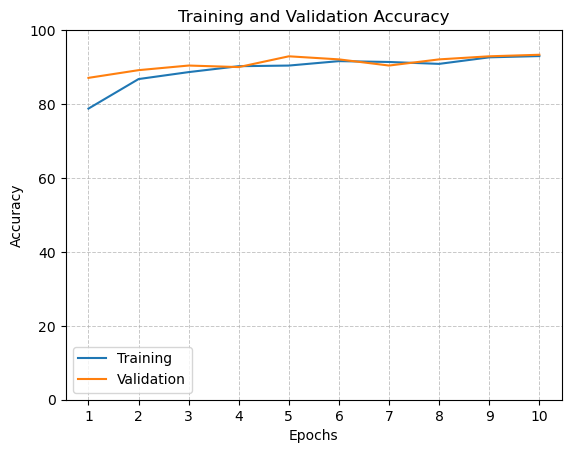

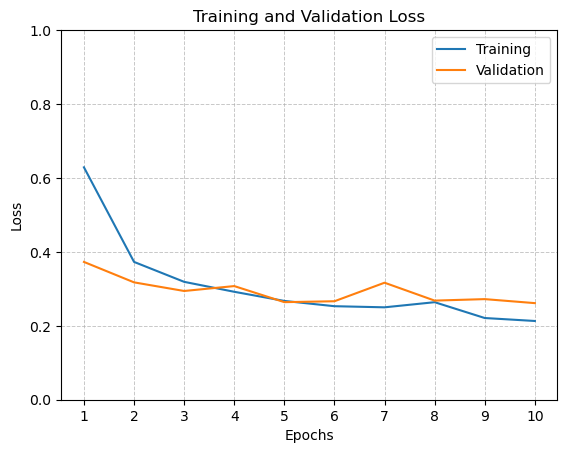

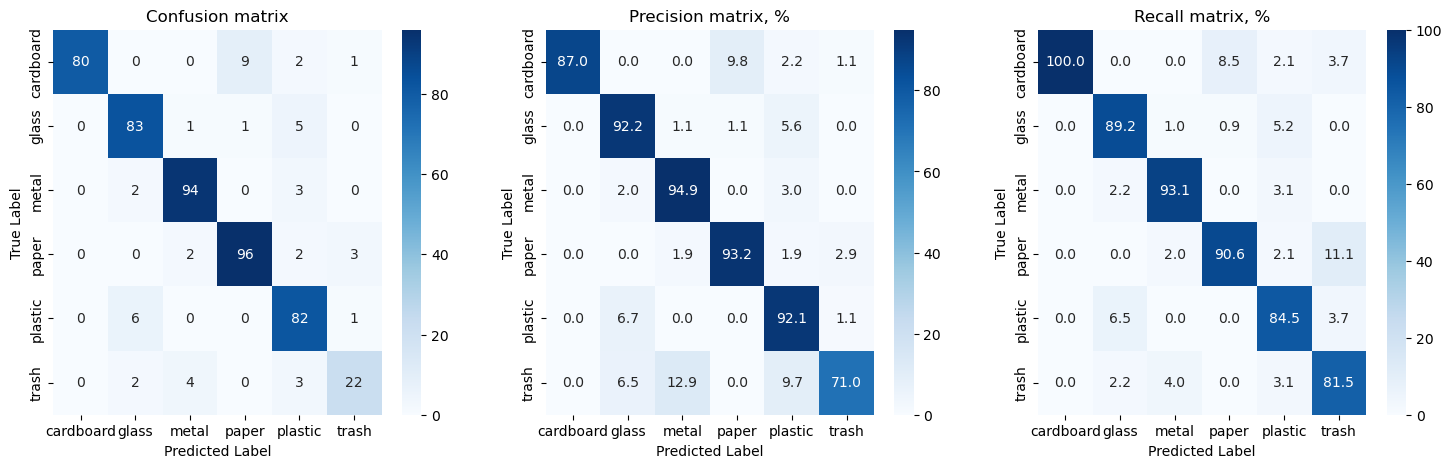

2025-02-19 00:33:03,747 - __main__ - DEBUG - Combination 2/21
2025-02-19 00:33:06,179 - __main__ - DEBUG - train_model() uses mps device
2025-02-19 00:33:06,181 - __main__ - DEBUG - From scratch: True
2025-02-19 00:33:06,181 - __main__ - DEBUG - Source folder: ../Data/raw
2025-02-19 00:33:06,182 - __main__ - DEBUG - New dataset folder: None
2025-02-19 00:33:06,182 - __main__ - DEBUG - Total namber of elements for training - 1770, validation - 252, testing - 505
2025-02-19 00:33:06,183 - __main__ - DEBUG - Learning Rate: 0.003, LR Decoy: 0.85, Batch size: 24
2025-02-19 00:34:42,984 - __main__ - DEBUG - Epoch [ 1/10]: Train Loss: 0.6697, Train Acc: 77.63%, Val Loss: 0.3989, Val Acc: 87.08%, Time:  97 sec
2025-02-19 00:36:15,919 - __main__ - DEBUG - Epoch [ 2/10]: Train Loss: 0.3897, Train Acc: 86.99%, Val Loss: 0.3315, Val Acc: 89.58%, Time:  93 sec
2025-02-19 00:37:45,837 - __main__ - DEBUG - Epoch [ 3/10]: Train Loss: 0.3269, Train Acc: 88.98%, Val Loss: 0.3112, Val Acc: 89.17%, Time: 

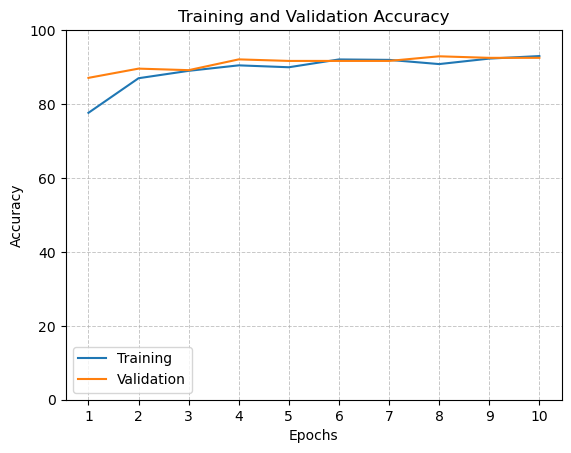

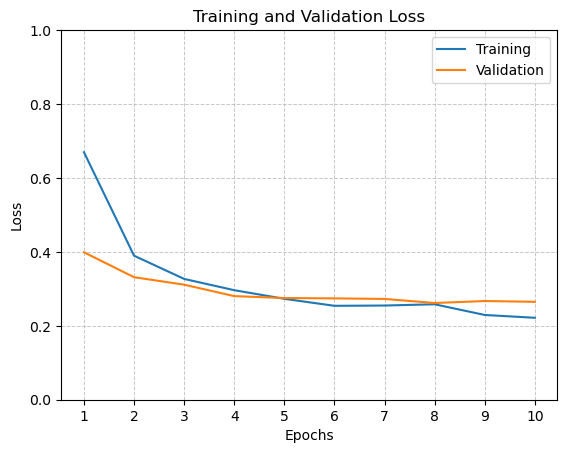

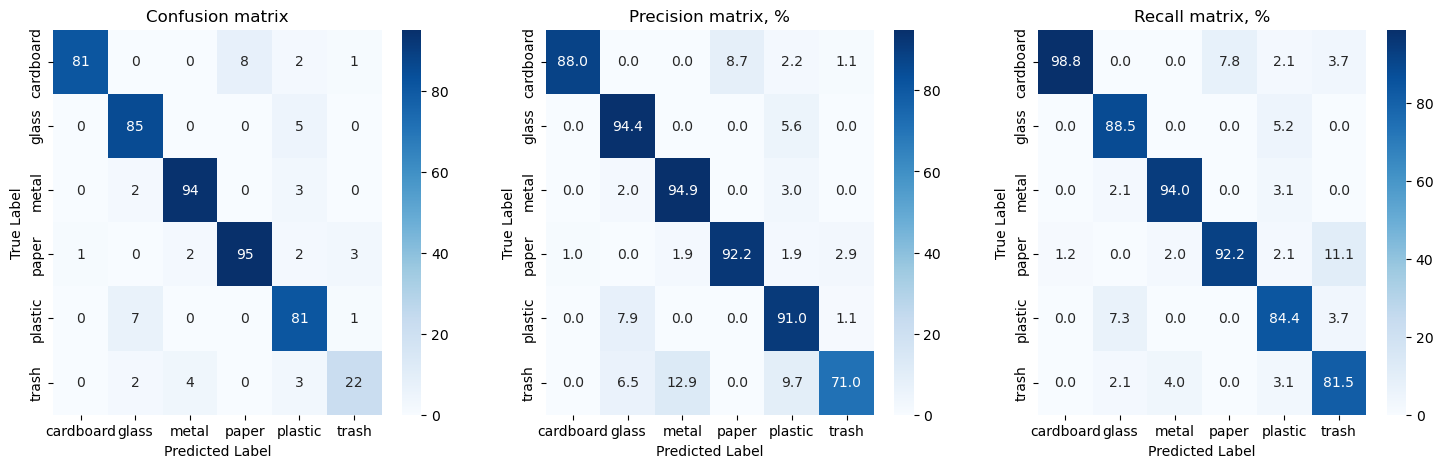

2025-02-19 00:50:26,671 - __main__ - DEBUG - Combination 3/21
2025-02-19 00:50:29,047 - __main__ - DEBUG - train_model() uses mps device
2025-02-19 00:50:29,054 - __main__ - DEBUG - From scratch: True
2025-02-19 00:50:29,054 - __main__ - DEBUG - Source folder: ../Data/raw
2025-02-19 00:50:29,055 - __main__ - DEBUG - New dataset folder: None
2025-02-19 00:50:29,055 - __main__ - DEBUG - Total namber of elements for training - 1770, validation - 252, testing - 505
2025-02-19 00:50:29,056 - __main__ - DEBUG - Learning Rate: 0.00275, LR Decoy: 0.85, Batch size: 24
2025-02-19 00:52:01,703 - __main__ - DEBUG - Epoch [ 1/10]: Train Loss: 0.6871, Train Acc: 77.17%, Val Loss: 0.4090, Val Acc: 86.67%, Time:  93 sec
2025-02-19 00:53:29,562 - __main__ - DEBUG - Epoch [ 2/10]: Train Loss: 0.3999, Train Acc: 86.70%, Val Loss: 0.3333, Val Acc: 88.75%, Time:  88 sec
2025-02-19 00:54:57,639 - __main__ - DEBUG - Epoch [ 3/10]: Train Loss: 0.3399, Train Acc: 88.81%, Val Loss: 0.3182, Val Acc: 88.33%, Time

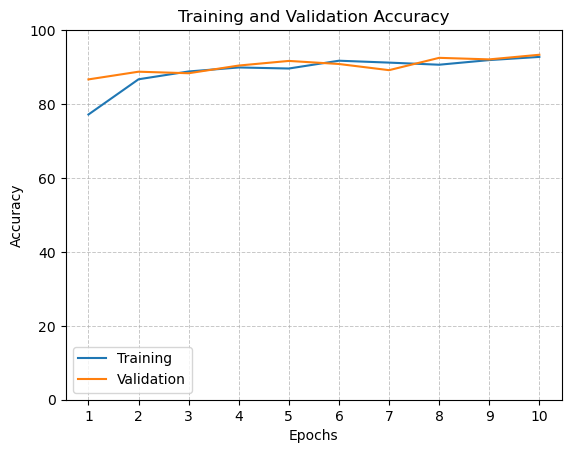

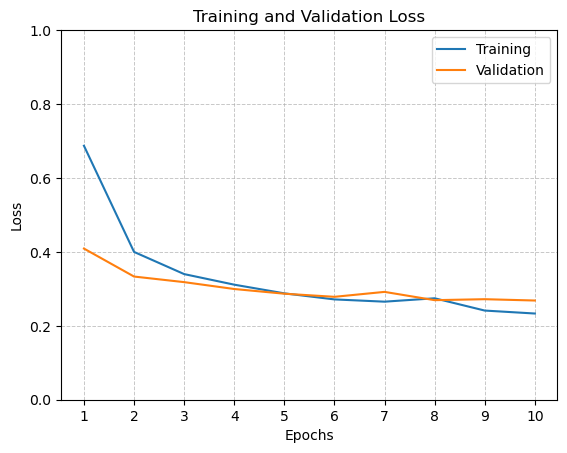

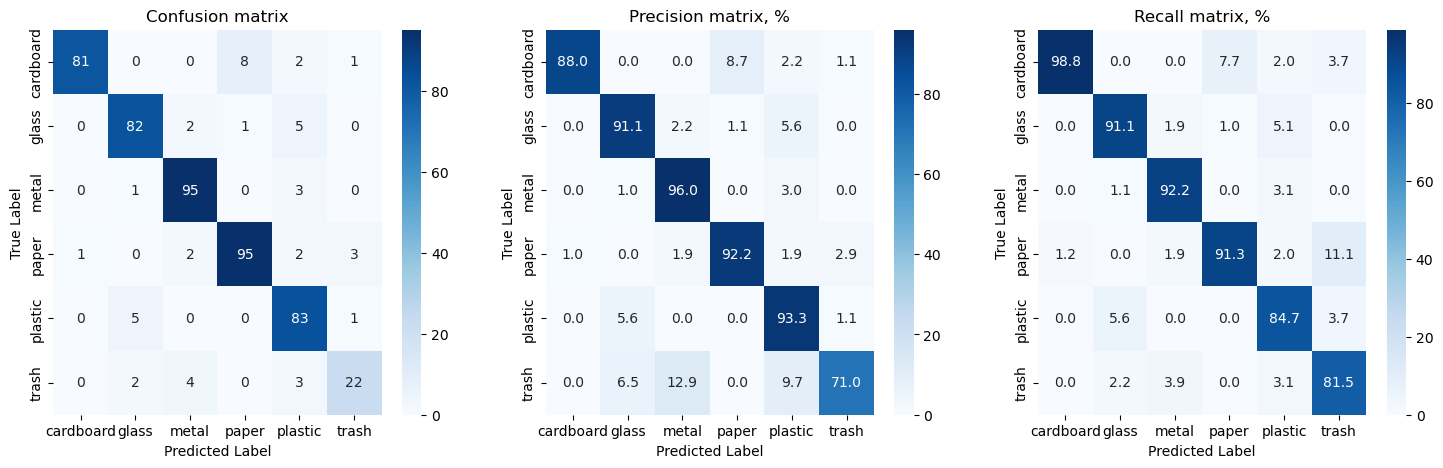

2025-02-19 01:06:39,954 - __main__ - DEBUG - Combination 4/21
2025-02-19 01:06:42,403 - __main__ - DEBUG - train_model() uses mps device
2025-02-19 01:06:42,413 - __main__ - DEBUG - From scratch: True
2025-02-19 01:06:42,414 - __main__ - DEBUG - Source folder: ../Data/raw
2025-02-19 01:06:42,414 - __main__ - DEBUG - New dataset folder: None
2025-02-19 01:06:42,414 - __main__ - DEBUG - Total namber of elements for training - 1770, validation - 252, testing - 505
2025-02-19 01:06:42,416 - __main__ - DEBUG - Learning Rate: 0.0025, LR Decoy: 0.85, Batch size: 24
2025-02-19 01:08:16,719 - __main__ - DEBUG - Epoch [ 1/10]: Train Loss: 0.7048, Train Acc: 77.05%, Val Loss: 0.4187, Val Acc: 87.08%, Time:  94 sec
2025-02-19 01:09:44,713 - __main__ - DEBUG - Epoch [ 2/10]: Train Loss: 0.4121, Train Acc: 86.59%, Val Loss: 0.3500, Val Acc: 88.75%, Time:  88 sec
2025-02-19 01:11:11,631 - __main__ - DEBUG - Epoch [ 3/10]: Train Loss: 0.3527, Train Acc: 88.13%, Val Loss: 0.3327, Val Acc: 89.17%, Time:

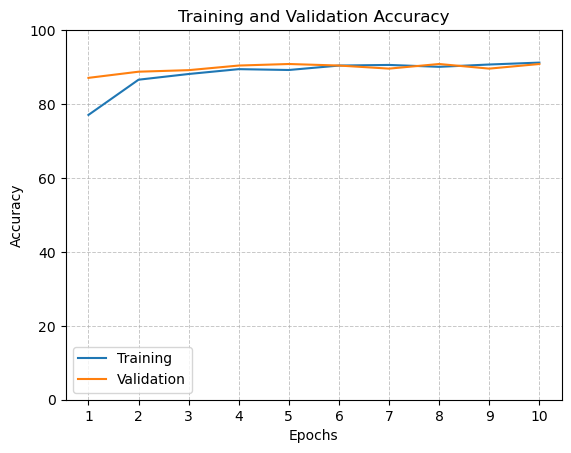

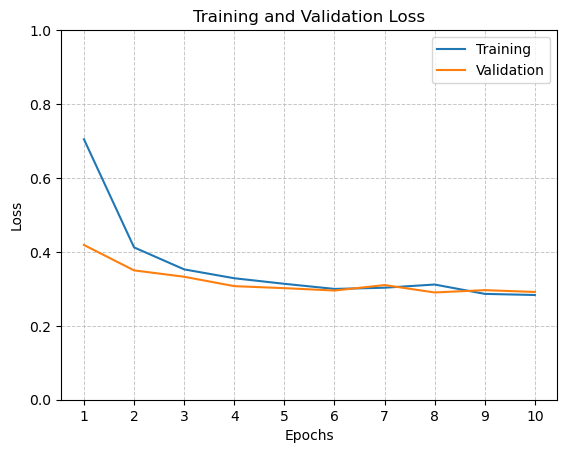

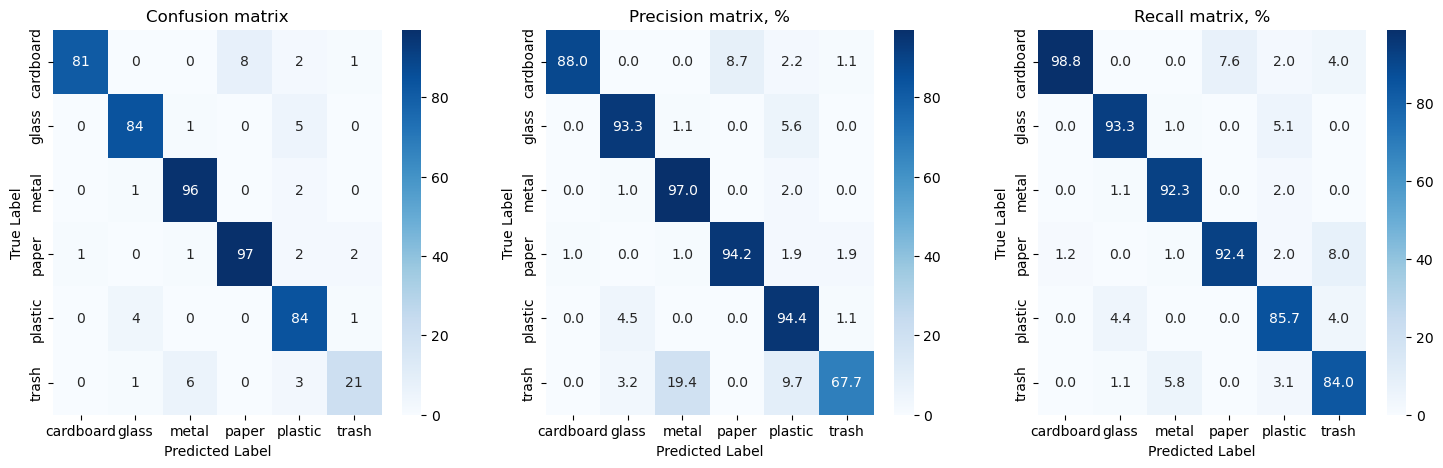

2025-02-19 01:22:49,983 - __main__ - DEBUG - Combination 5/21
2025-02-19 01:22:52,581 - __main__ - DEBUG - train_model() uses mps device
2025-02-19 01:22:52,582 - __main__ - DEBUG - From scratch: True
2025-02-19 01:22:52,582 - __main__ - DEBUG - Source folder: ../Data/raw
2025-02-19 01:22:52,582 - __main__ - DEBUG - New dataset folder: None
2025-02-19 01:22:52,582 - __main__ - DEBUG - Total namber of elements for training - 1770, validation - 252, testing - 505
2025-02-19 01:22:52,583 - __main__ - DEBUG - Learning Rate: 0.00225, LR Decoy: 0.85, Batch size: 24
2025-02-19 01:24:25,649 - __main__ - DEBUG - Epoch [ 1/10]: Train Loss: 0.7272, Train Acc: 76.43%, Val Loss: 0.4212, Val Acc: 86.25%, Time:  93 sec
2025-02-19 01:25:53,143 - __main__ - DEBUG - Epoch [ 2/10]: Train Loss: 0.4177, Train Acc: 86.42%, Val Loss: 0.3336, Val Acc: 90.00%, Time:  87 sec
2025-02-19 01:27:20,751 - __main__ - DEBUG - Epoch [ 3/10]: Train Loss: 0.3577, Train Acc: 88.13%, Val Loss: 0.3126, Val Acc: 90.83%, Time

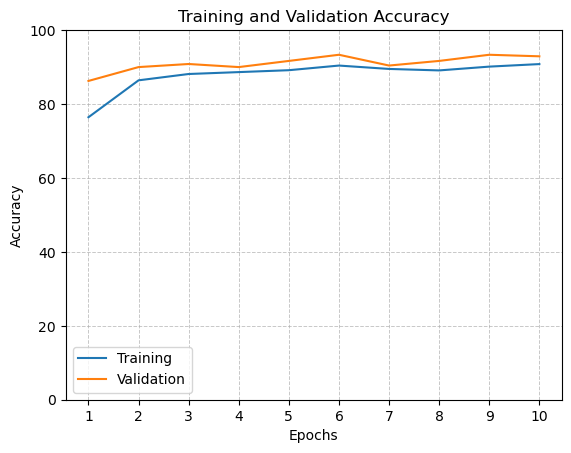

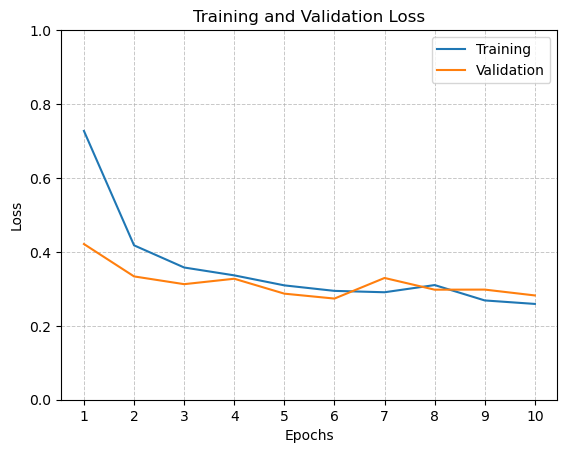

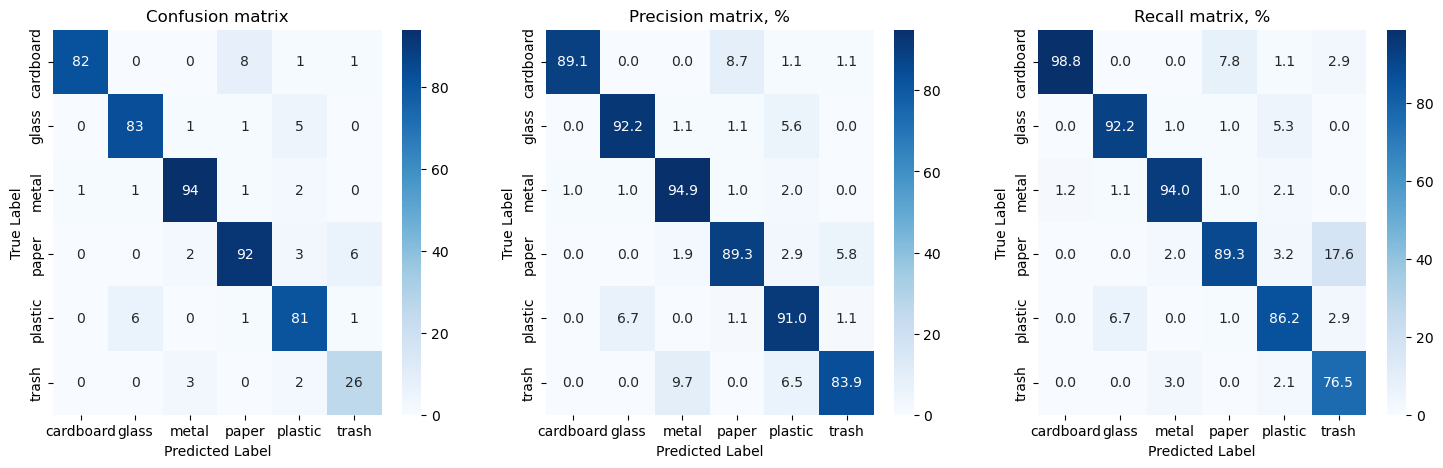

2025-02-19 01:38:59,710 - __main__ - DEBUG - Combination 6/21
2025-02-19 01:39:02,165 - __main__ - DEBUG - train_model() uses mps device
2025-02-19 01:39:02,173 - __main__ - DEBUG - From scratch: True
2025-02-19 01:39:02,174 - __main__ - DEBUG - Source folder: ../Data/raw
2025-02-19 01:39:02,174 - __main__ - DEBUG - New dataset folder: None
2025-02-19 01:39:02,174 - __main__ - DEBUG - Total namber of elements for training - 1770, validation - 252, testing - 505
2025-02-19 01:39:02,175 - __main__ - DEBUG - Learning Rate: 0.002, LR Decoy: 0.85, Batch size: 24
2025-02-19 01:40:35,565 - __main__ - DEBUG - Epoch [ 1/10]: Train Loss: 0.7557, Train Acc: 75.91%, Val Loss: 0.4525, Val Acc: 86.67%, Time:  93 sec
2025-02-19 01:42:03,351 - __main__ - DEBUG - Epoch [ 2/10]: Train Loss: 0.4441, Train Acc: 85.39%, Val Loss: 0.3712, Val Acc: 87.50%, Time:  88 sec
2025-02-19 01:43:30,798 - __main__ - DEBUG - Epoch [ 3/10]: Train Loss: 0.3837, Train Acc: 87.56%, Val Loss: 0.3393, Val Acc: 88.75%, Time: 

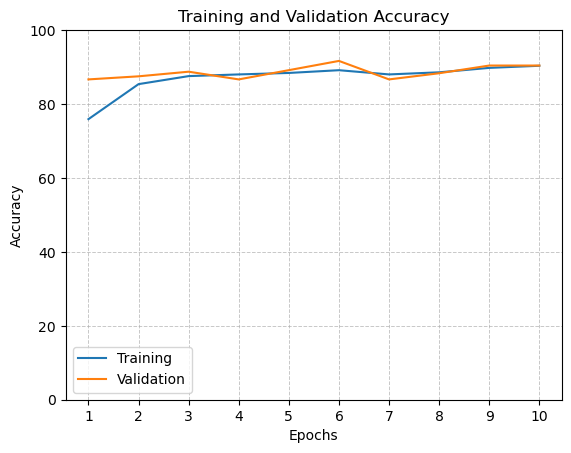

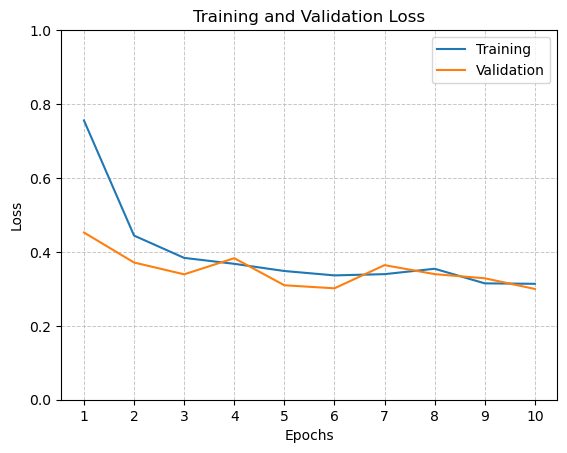

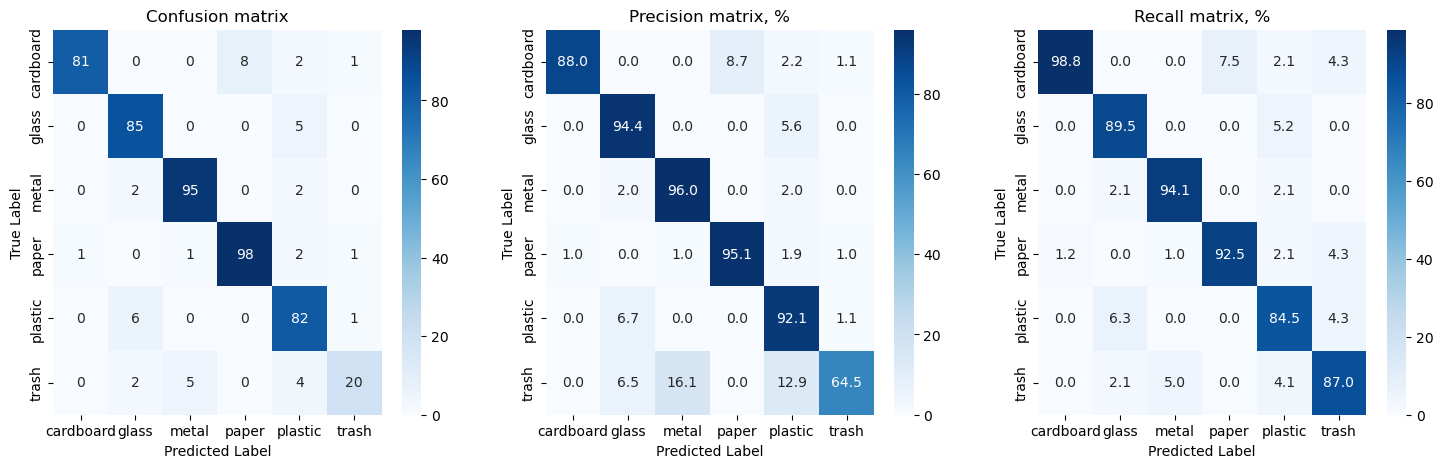

2025-02-19 01:55:13,378 - __main__ - DEBUG - Combination 7/21
2025-02-19 01:55:15,738 - __main__ - DEBUG - train_model() uses mps device
2025-02-19 01:55:15,739 - __main__ - DEBUG - From scratch: True
2025-02-19 01:55:15,739 - __main__ - DEBUG - Source folder: ../Data/raw
2025-02-19 01:55:15,739 - __main__ - DEBUG - New dataset folder: None
2025-02-19 01:55:15,740 - __main__ - DEBUG - Total namber of elements for training - 1770, validation - 252, testing - 505
2025-02-19 01:55:15,741 - __main__ - DEBUG - Learning Rate: 0.001, LR Decoy: 0.85, Batch size: 24
2025-02-19 01:56:48,900 - __main__ - DEBUG - Epoch [ 1/10]: Train Loss: 0.9504, Train Acc: 70.55%, Val Loss: 0.5484, Val Acc: 85.42%, Time:  93 sec
2025-02-19 01:58:19,305 - __main__ - DEBUG - Epoch [ 2/10]: Train Loss: 0.5366, Train Acc: 83.73%, Val Loss: 0.4327, Val Acc: 85.83%, Time:  90 sec
2025-02-19 01:59:48,485 - __main__ - DEBUG - Epoch [ 3/10]: Train Loss: 0.4491, Train Acc: 86.87%, Val Loss: 0.3937, Val Acc: 86.67%, Time: 

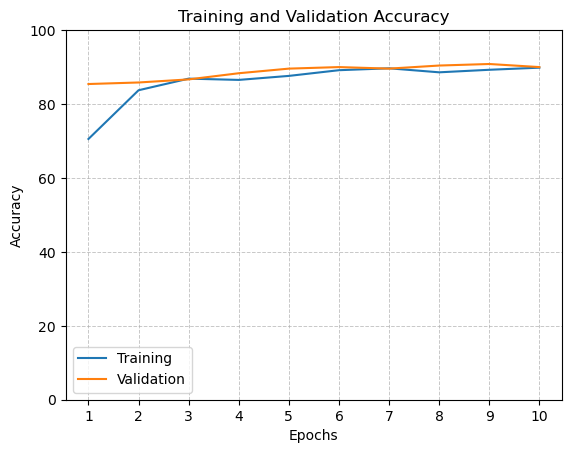

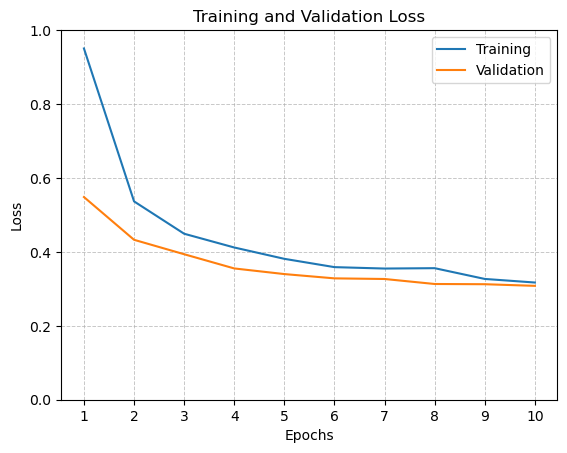

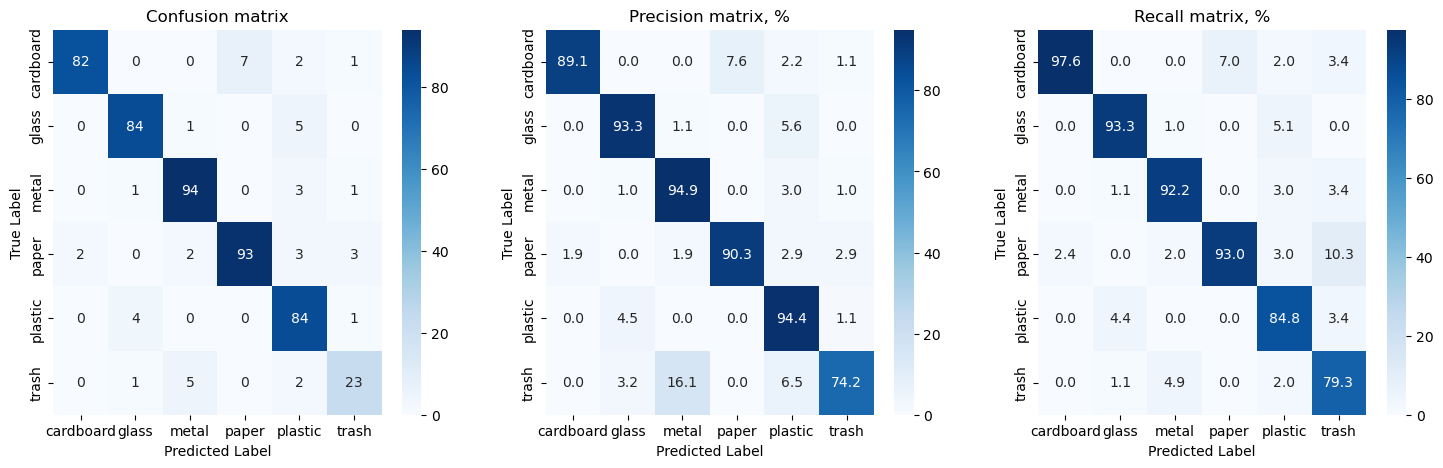

2025-02-19 02:11:31,196 - __main__ - DEBUG - Combination 8/21
2025-02-19 02:11:33,663 - __main__ - DEBUG - train_model() uses mps device
2025-02-19 02:11:33,671 - __main__ - DEBUG - From scratch: True
2025-02-19 02:11:33,672 - __main__ - DEBUG - Source folder: ../Data/raw
2025-02-19 02:11:33,672 - __main__ - DEBUG - New dataset folder: None
2025-02-19 02:11:33,672 - __main__ - DEBUG - Total namber of elements for training - 1770, validation - 252, testing - 505
2025-02-19 02:11:33,674 - __main__ - DEBUG - Learning Rate: 0.004, LR Decoy: 0.8, Batch size: 24
2025-02-19 02:13:06,693 - __main__ - DEBUG - Epoch [ 1/10]: Train Loss: 0.6289, Train Acc: 78.77%, Val Loss: 0.3574, Val Acc: 86.67%, Time:  93 sec
2025-02-19 02:14:34,699 - __main__ - DEBUG - Epoch [ 2/10]: Train Loss: 0.3832, Train Acc: 86.07%, Val Loss: 0.3074, Val Acc: 90.42%, Time:  88 sec
2025-02-19 02:16:02,281 - __main__ - DEBUG - Epoch [ 3/10]: Train Loss: 0.3404, Train Acc: 88.53%, Val Loss: 0.3029, Val Acc: 92.50%, Time:  

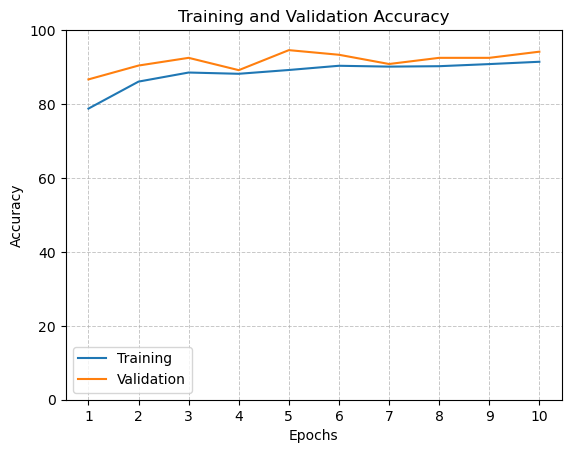

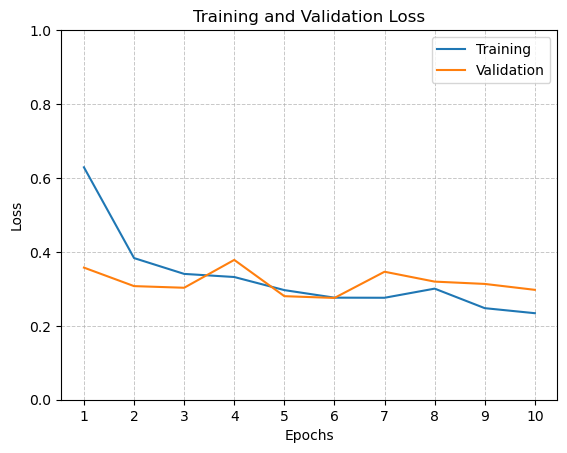

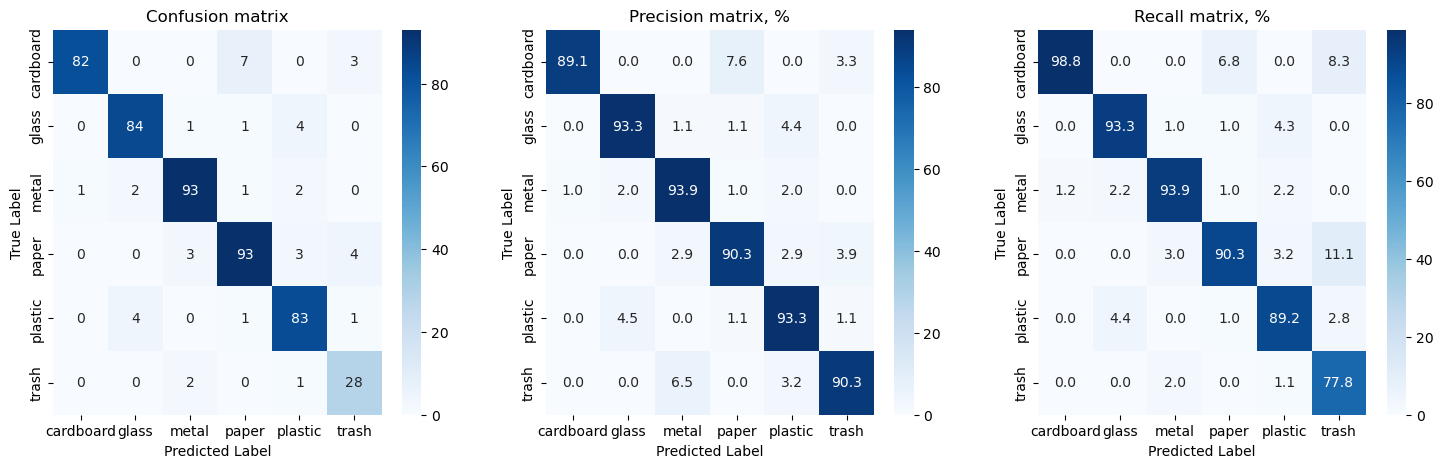

2025-02-19 02:27:43,058 - __main__ - DEBUG - Combination 9/21
2025-02-19 02:27:45,639 - __main__ - DEBUG - train_model() uses mps device
2025-02-19 02:27:45,647 - __main__ - DEBUG - From scratch: True
2025-02-19 02:27:45,648 - __main__ - DEBUG - Source folder: ../Data/raw
2025-02-19 02:27:45,648 - __main__ - DEBUG - New dataset folder: None
2025-02-19 02:27:45,648 - __main__ - DEBUG - Total namber of elements for training - 1770, validation - 252, testing - 505
2025-02-19 02:27:45,649 - __main__ - DEBUG - Learning Rate: 0.003, LR Decoy: 0.8, Batch size: 24
2025-02-19 02:29:17,926 - __main__ - DEBUG - Epoch [ 1/10]: Train Loss: 0.6734, Train Acc: 77.63%, Val Loss: 0.3880, Val Acc: 87.08%, Time:  92 sec
2025-02-19 02:30:45,971 - __main__ - DEBUG - Epoch [ 2/10]: Train Loss: 0.4105, Train Acc: 85.33%, Val Loss: 0.3021, Val Acc: 90.00%, Time:  88 sec
2025-02-19 02:32:13,716 - __main__ - DEBUG - Epoch [ 3/10]: Train Loss: 0.3607, Train Acc: 87.16%, Val Loss: 0.3359, Val Acc: 88.75%, Time:  

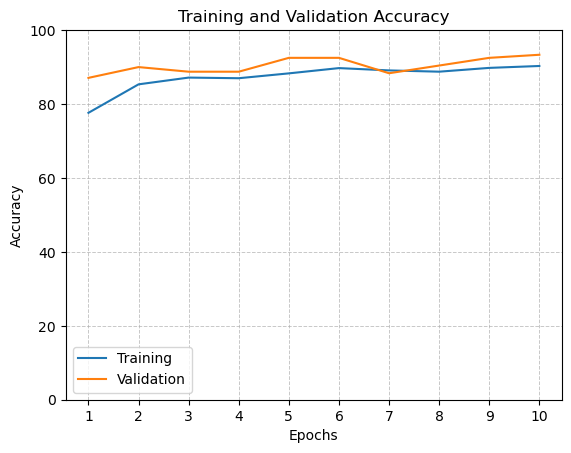

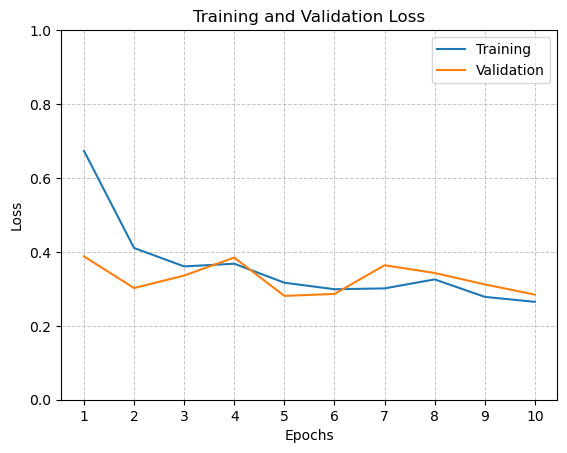

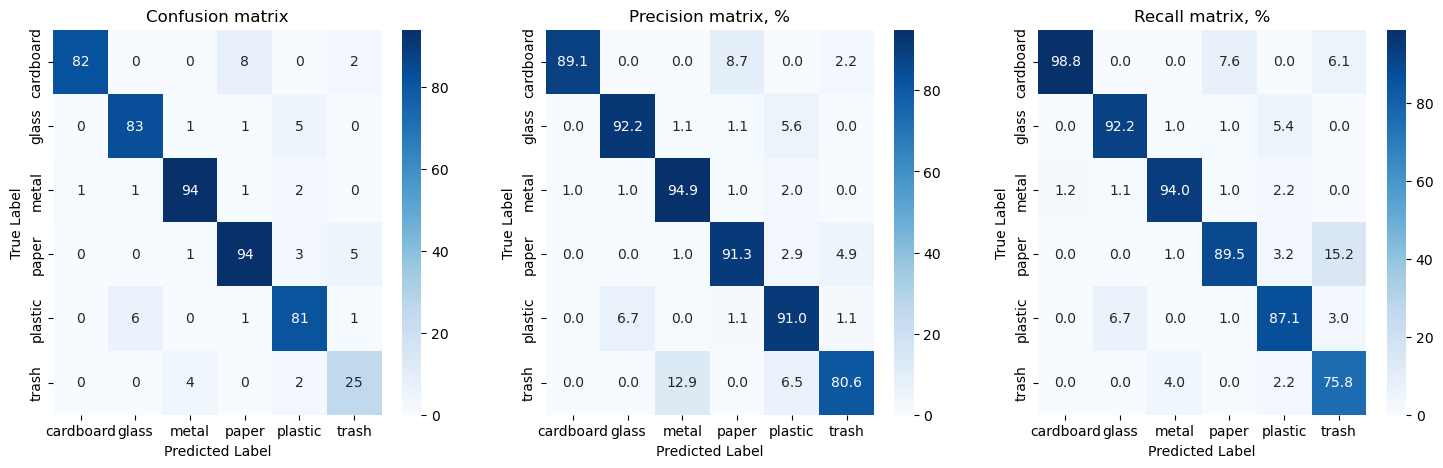

2025-02-19 02:43:52,854 - __main__ - DEBUG - Combination 10/21
2025-02-19 02:43:55,672 - __main__ - DEBUG - train_model() uses mps device
2025-02-19 02:43:55,677 - __main__ - DEBUG - From scratch: True
2025-02-19 02:43:55,677 - __main__ - DEBUG - Source folder: ../Data/raw
2025-02-19 02:43:55,678 - __main__ - DEBUG - New dataset folder: None
2025-02-19 02:43:55,678 - __main__ - DEBUG - Total namber of elements for training - 1770, validation - 252, testing - 505
2025-02-19 02:43:55,680 - __main__ - DEBUG - Learning Rate: 0.00275, LR Decoy: 0.8, Batch size: 24
2025-02-19 02:45:29,746 - __main__ - DEBUG - Epoch [ 1/10]: Train Loss: 0.6871, Train Acc: 77.28%, Val Loss: 0.4026, Val Acc: 86.67%, Time:  94 sec
2025-02-19 02:46:57,623 - __main__ - DEBUG - Epoch [ 2/10]: Train Loss: 0.4012, Train Acc: 86.47%, Val Loss: 0.3241, Val Acc: 89.17%, Time:  88 sec
2025-02-19 02:48:24,789 - __main__ - DEBUG - Epoch [ 3/10]: Train Loss: 0.3452, Train Acc: 88.24%, Val Loss: 0.3005, Val Acc: 91.25%, Time

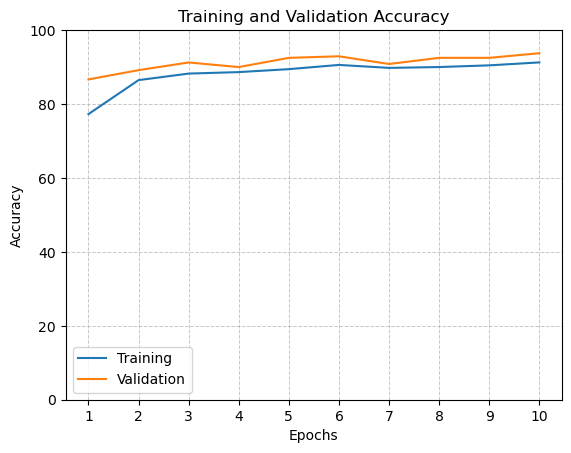

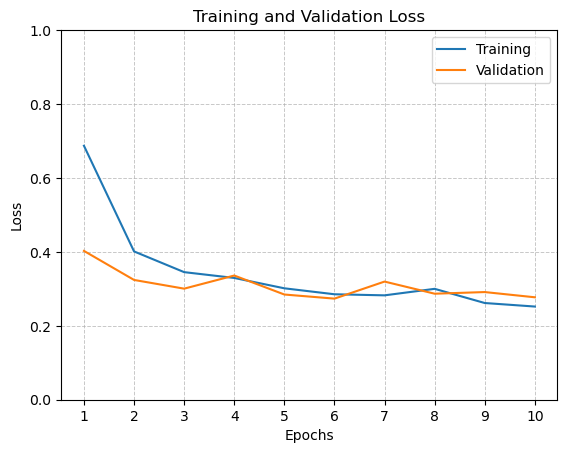

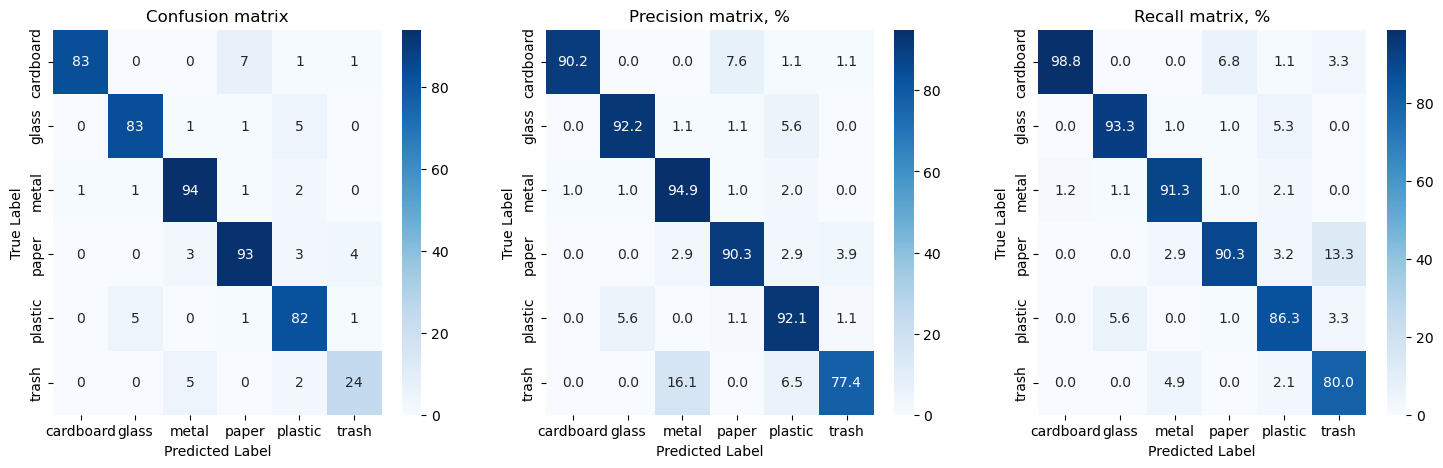

2025-02-19 03:00:05,009 - __main__ - DEBUG - Combination 11/21
2025-02-19 03:00:07,409 - __main__ - DEBUG - train_model() uses mps device
2025-02-19 03:00:07,409 - __main__ - DEBUG - From scratch: True
2025-02-19 03:00:07,410 - __main__ - DEBUG - Source folder: ../Data/raw
2025-02-19 03:00:07,410 - __main__ - DEBUG - New dataset folder: None
2025-02-19 03:00:07,410 - __main__ - DEBUG - Total namber of elements for training - 1770, validation - 252, testing - 505
2025-02-19 03:00:07,412 - __main__ - DEBUG - Learning Rate: 0.0025, LR Decoy: 0.8, Batch size: 24
2025-02-19 03:01:41,588 - __main__ - DEBUG - Epoch [ 1/10]: Train Loss: 0.7073, Train Acc: 76.83%, Val Loss: 0.4143, Val Acc: 86.25%, Time:  94 sec
2025-02-19 03:03:08,862 - __main__ - DEBUG - Epoch [ 2/10]: Train Loss: 0.4169, Train Acc: 85.67%, Val Loss: 0.3347, Val Acc: 88.33%, Time:  87 sec
2025-02-19 03:04:35,522 - __main__ - DEBUG - Epoch [ 3/10]: Train Loss: 0.3588, Train Acc: 87.67%, Val Loss: 0.3048, Val Acc: 92.08%, Time:

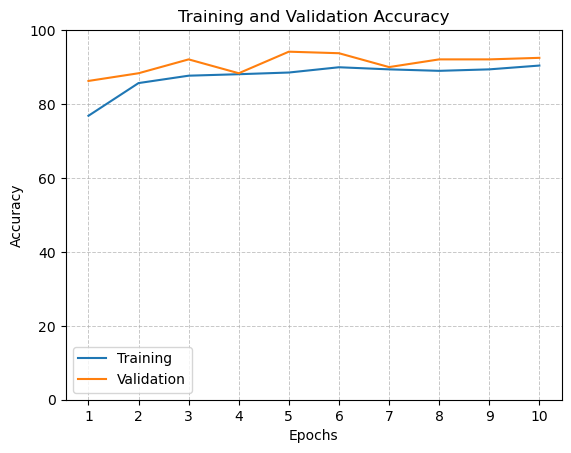

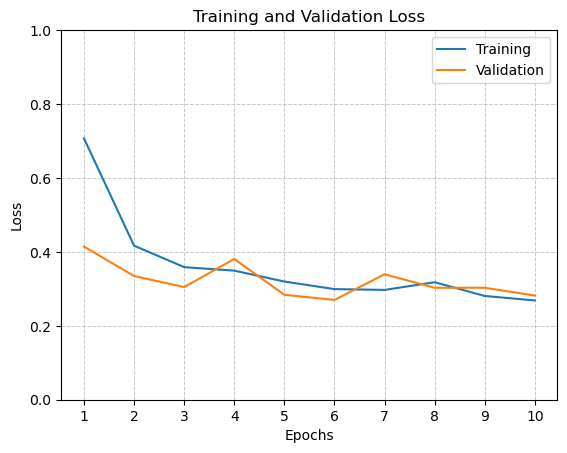

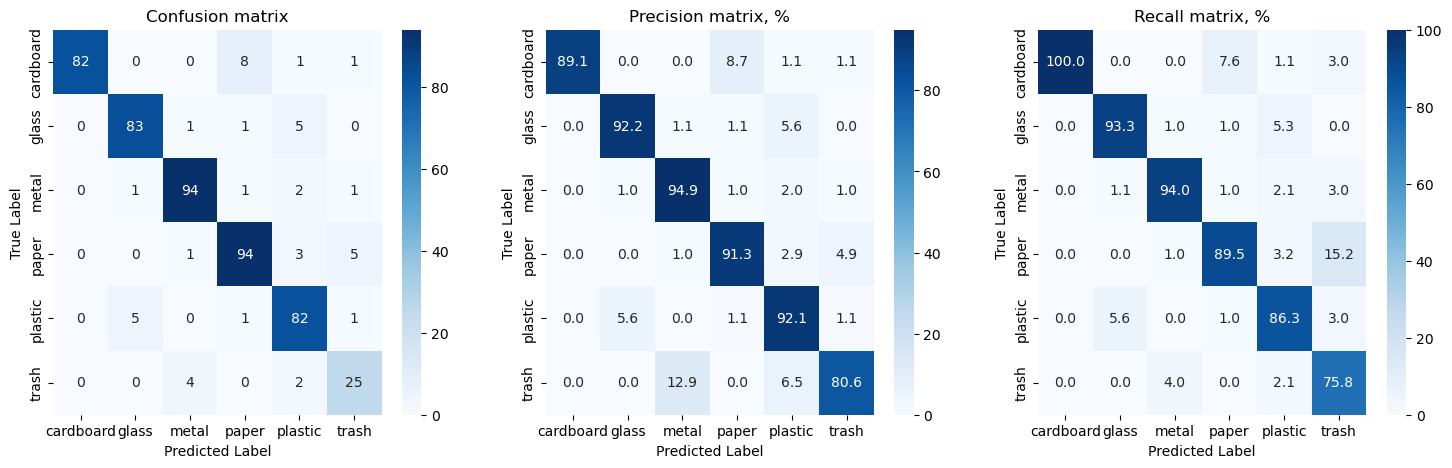

2025-02-19 03:16:16,066 - __main__ - DEBUG - Combination 12/21
2025-02-19 03:16:18,411 - __main__ - DEBUG - train_model() uses mps device
2025-02-19 03:16:18,416 - __main__ - DEBUG - From scratch: True
2025-02-19 03:16:18,416 - __main__ - DEBUG - Source folder: ../Data/raw
2025-02-19 03:16:18,416 - __main__ - DEBUG - New dataset folder: None
2025-02-19 03:16:18,417 - __main__ - DEBUG - Total namber of elements for training - 1770, validation - 252, testing - 505
2025-02-19 03:16:18,418 - __main__ - DEBUG - Learning Rate: 0.00225, LR Decoy: 0.8, Batch size: 24
2025-02-19 03:17:51,821 - __main__ - DEBUG - Epoch [ 1/10]: Train Loss: 0.7286, Train Acc: 76.31%, Val Loss: 0.4277, Val Acc: 86.25%, Time:  93 sec
2025-02-19 03:19:20,015 - __main__ - DEBUG - Epoch [ 2/10]: Train Loss: 0.4245, Train Acc: 85.45%, Val Loss: 0.3467, Val Acc: 88.33%, Time:  88 sec
2025-02-19 03:20:47,210 - __main__ - DEBUG - Epoch [ 3/10]: Train Loss: 0.3634, Train Acc: 87.90%, Val Loss: 0.3100, Val Acc: 91.25%, Time

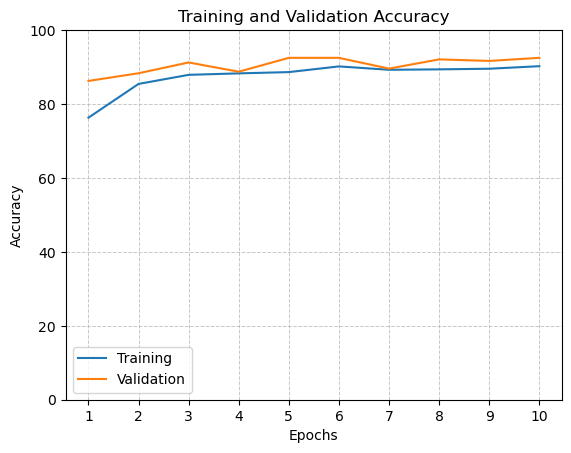

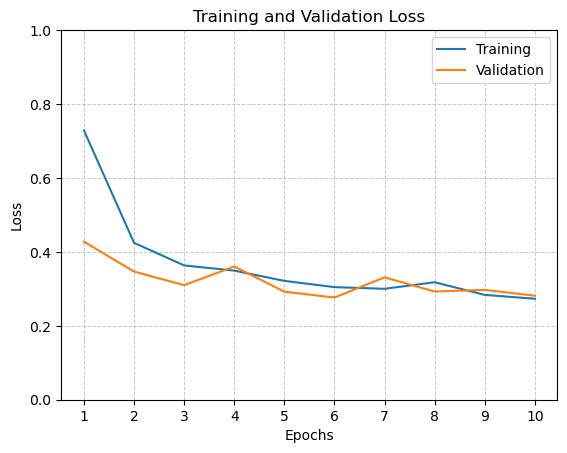

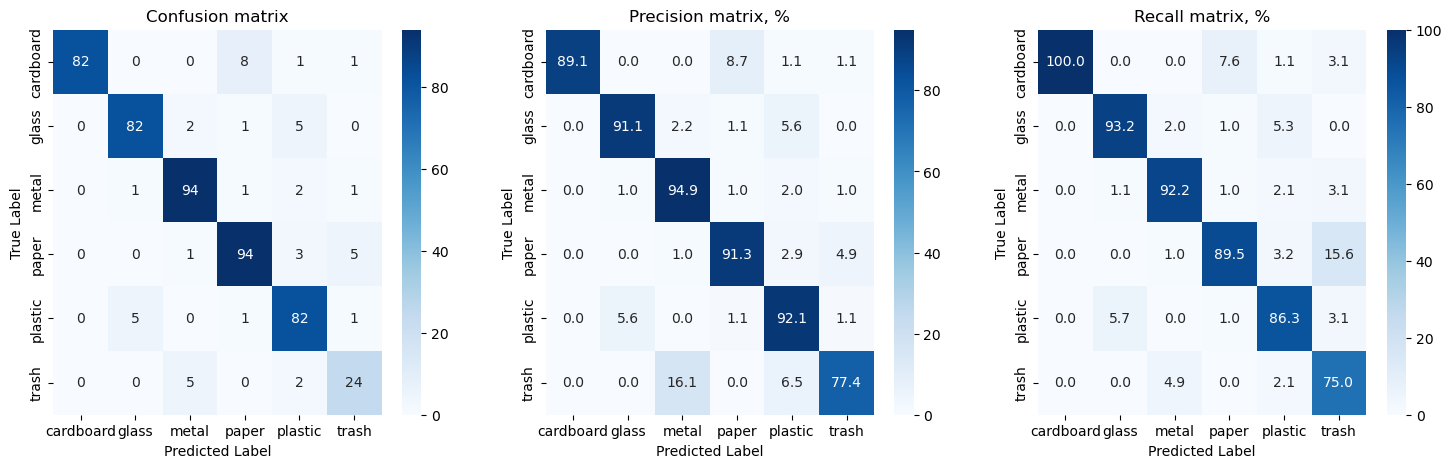

2025-02-19 03:32:27,117 - __main__ - DEBUG - Combination 13/21
2025-02-19 03:32:30,097 - __main__ - DEBUG - train_model() uses mps device
2025-02-19 03:32:30,098 - __main__ - DEBUG - From scratch: True
2025-02-19 03:32:30,098 - __main__ - DEBUG - Source folder: ../Data/raw
2025-02-19 03:32:30,098 - __main__ - DEBUG - New dataset folder: None
2025-02-19 03:32:30,099 - __main__ - DEBUG - Total namber of elements for training - 1770, validation - 252, testing - 505
2025-02-19 03:32:30,100 - __main__ - DEBUG - Learning Rate: 0.002, LR Decoy: 0.8, Batch size: 24
2025-02-19 03:34:02,803 - __main__ - DEBUG - Epoch [ 1/10]: Train Loss: 0.7532, Train Acc: 75.86%, Val Loss: 0.4318, Val Acc: 85.83%, Time:  93 sec
2025-02-19 03:35:31,318 - __main__ - DEBUG - Epoch [ 2/10]: Train Loss: 0.4294, Train Acc: 86.36%, Val Loss: 0.3517, Val Acc: 88.75%, Time:  89 sec
2025-02-19 03:36:58,604 - __main__ - DEBUG - Epoch [ 3/10]: Train Loss: 0.3653, Train Acc: 88.47%, Val Loss: 0.3322, Val Acc: 90.00%, Time: 

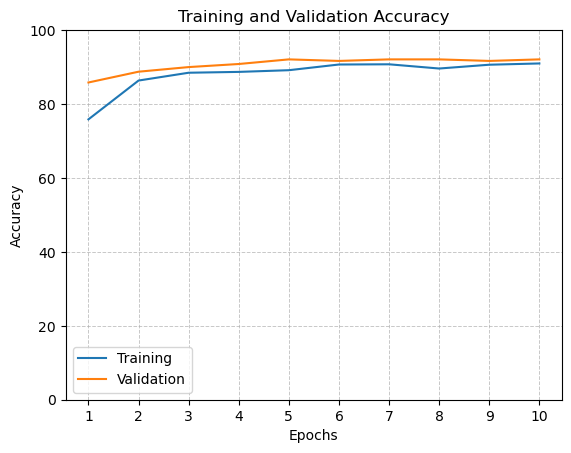

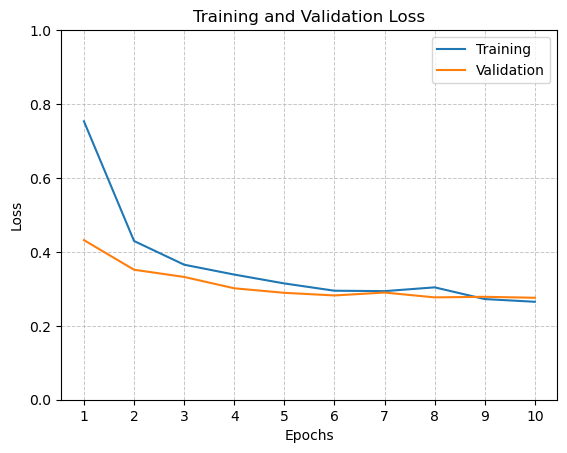

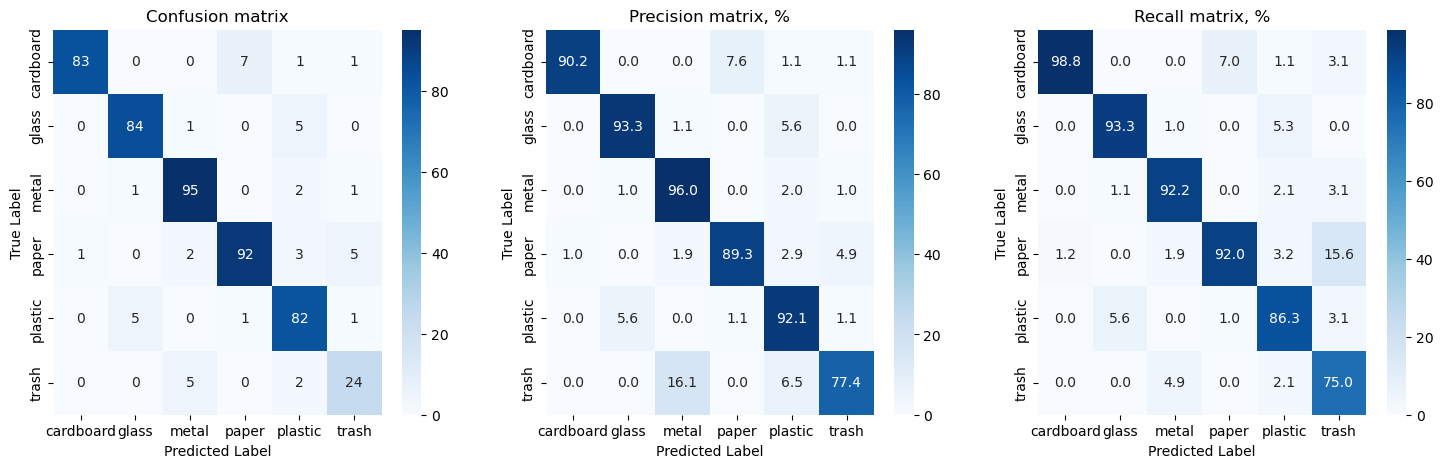

2025-02-19 03:48:38,900 - __main__ - DEBUG - Combination 14/21
2025-02-19 03:48:41,581 - __main__ - DEBUG - train_model() uses mps device
2025-02-19 03:48:41,582 - __main__ - DEBUG - From scratch: True
2025-02-19 03:48:41,582 - __main__ - DEBUG - Source folder: ../Data/raw
2025-02-19 03:48:41,582 - __main__ - DEBUG - New dataset folder: None
2025-02-19 03:48:41,582 - __main__ - DEBUG - Total namber of elements for training - 1770, validation - 252, testing - 505
2025-02-19 03:48:41,584 - __main__ - DEBUG - Learning Rate: 0.001, LR Decoy: 0.8, Batch size: 24
2025-02-19 03:50:14,417 - __main__ - DEBUG - Epoch [ 1/10]: Train Loss: 0.9504, Train Acc: 70.55%, Val Loss: 0.5482, Val Acc: 85.42%, Time:  93 sec
2025-02-19 03:51:41,771 - __main__ - DEBUG - Epoch [ 2/10]: Train Loss: 0.5394, Train Acc: 83.73%, Val Loss: 0.4364, Val Acc: 86.25%, Time:  87 sec
2025-02-19 03:53:11,511 - __main__ - DEBUG - Epoch [ 3/10]: Train Loss: 0.4548, Train Acc: 86.70%, Val Loss: 0.3995, Val Acc: 86.25%, Time: 

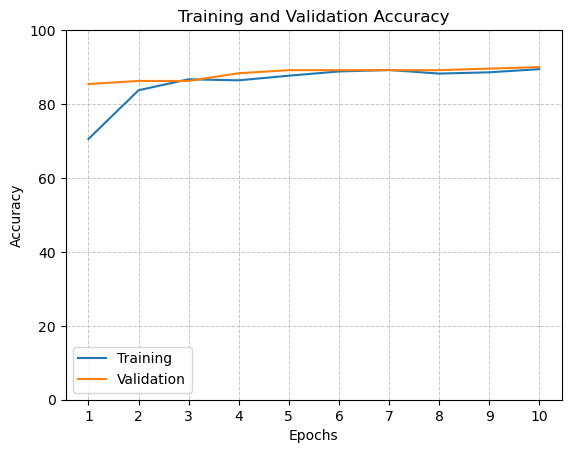

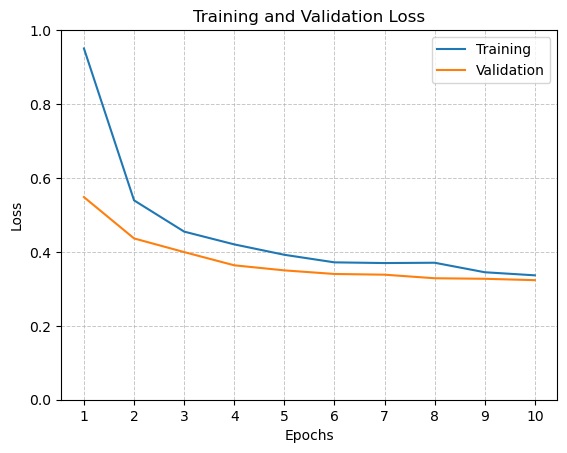

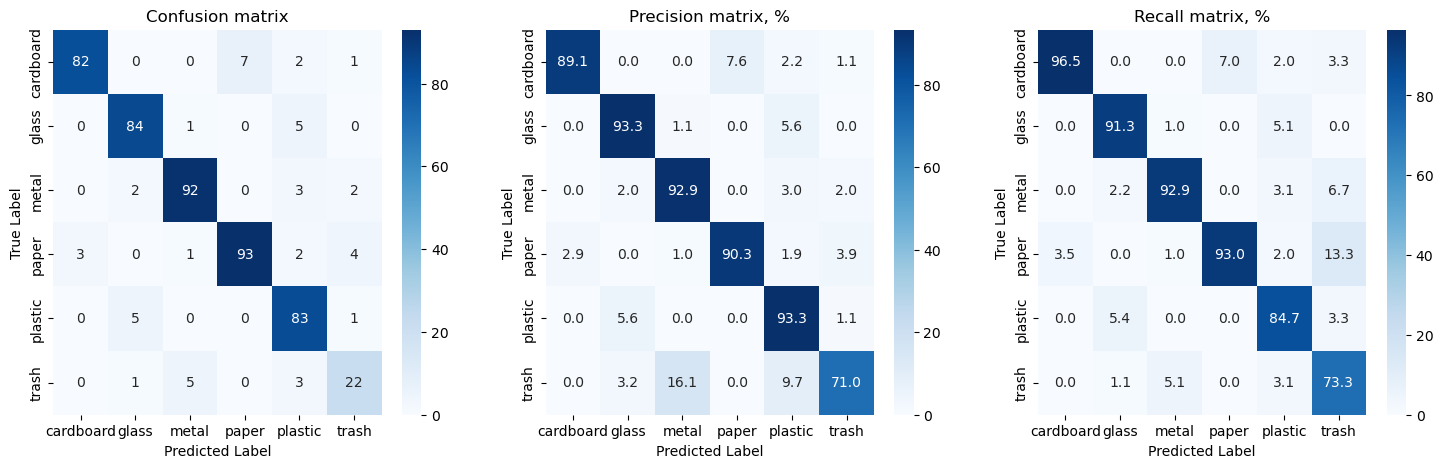

2025-02-19 04:04:51,882 - __main__ - DEBUG - Combination 15/21
2025-02-19 04:04:54,406 - __main__ - DEBUG - train_model() uses mps device
2025-02-19 04:04:54,414 - __main__ - DEBUG - From scratch: True
2025-02-19 04:04:54,414 - __main__ - DEBUG - Source folder: ../Data/raw
2025-02-19 04:04:54,415 - __main__ - DEBUG - New dataset folder: None
2025-02-19 04:04:54,415 - __main__ - DEBUG - Total namber of elements for training - 1770, validation - 252, testing - 505
2025-02-19 04:04:54,416 - __main__ - DEBUG - Learning Rate: 0.004, LR Decoy: 0.75, Batch size: 24
2025-02-19 04:06:27,122 - __main__ - DEBUG - Epoch [ 1/10]: Train Loss: 0.6293, Train Acc: 78.82%, Val Loss: 0.3567, Val Acc: 87.08%, Time:  93 sec
2025-02-19 04:07:55,293 - __main__ - DEBUG - Epoch [ 2/10]: Train Loss: 0.3895, Train Acc: 86.36%, Val Loss: 0.2950, Val Acc: 91.25%, Time:  88 sec
2025-02-19 04:09:22,843 - __main__ - DEBUG - Epoch [ 3/10]: Train Loss: 0.3431, Train Acc: 87.67%, Val Loss: 0.3049, Val Acc: 92.50%, Time:

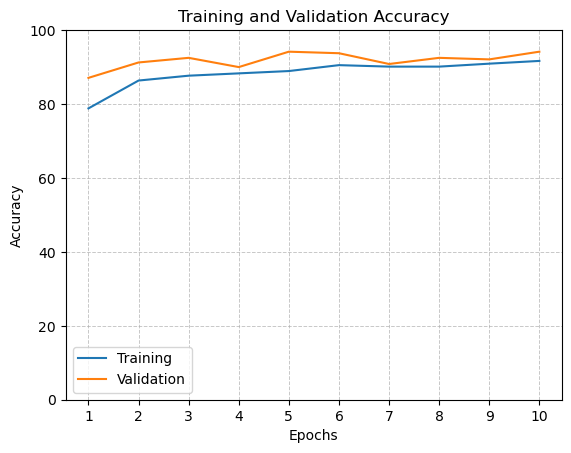

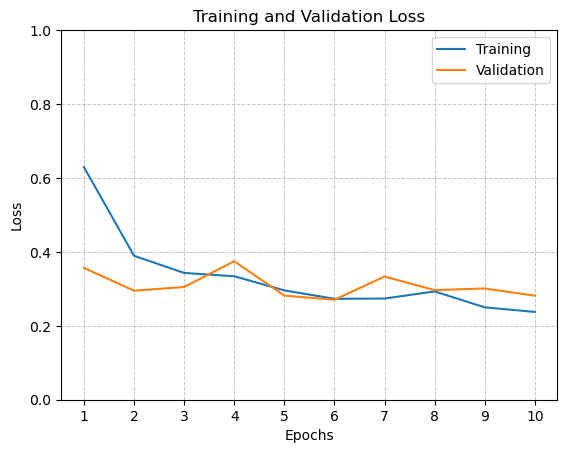

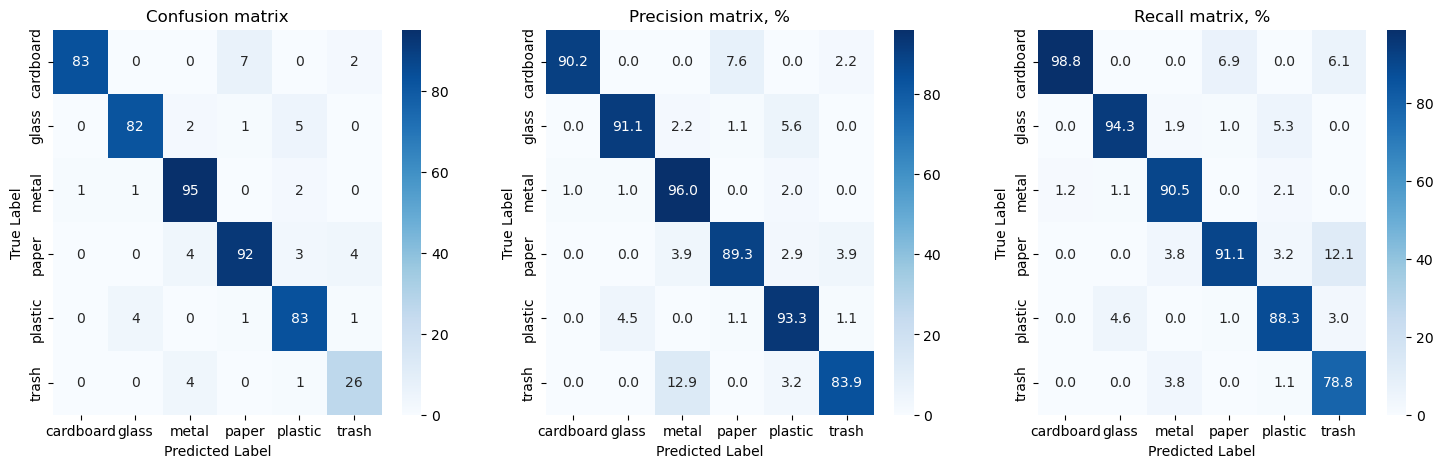

2025-02-19 04:21:05,551 - __main__ - DEBUG - Combination 16/21
2025-02-19 04:21:08,482 - __main__ - DEBUG - train_model() uses mps device
2025-02-19 04:21:08,490 - __main__ - DEBUG - From scratch: True
2025-02-19 04:21:08,491 - __main__ - DEBUG - Source folder: ../Data/raw
2025-02-19 04:21:08,491 - __main__ - DEBUG - New dataset folder: None
2025-02-19 04:21:08,491 - __main__ - DEBUG - Total namber of elements for training - 1770, validation - 252, testing - 505
2025-02-19 04:21:08,493 - __main__ - DEBUG - Learning Rate: 0.003, LR Decoy: 0.75, Batch size: 24
2025-02-19 04:22:41,858 - __main__ - DEBUG - Epoch [ 1/10]: Train Loss: 0.6734, Train Acc: 77.63%, Val Loss: 0.3879, Val Acc: 87.08%, Time:  93 sec
2025-02-19 04:24:09,572 - __main__ - DEBUG - Epoch [ 2/10]: Train Loss: 0.4082, Train Acc: 85.33%, Val Loss: 0.3069, Val Acc: 90.00%, Time:  88 sec
2025-02-19 04:25:38,098 - __main__ - DEBUG - Epoch [ 3/10]: Train Loss: 0.3544, Train Acc: 87.33%, Val Loss: 0.3079, Val Acc: 91.67%, Time:

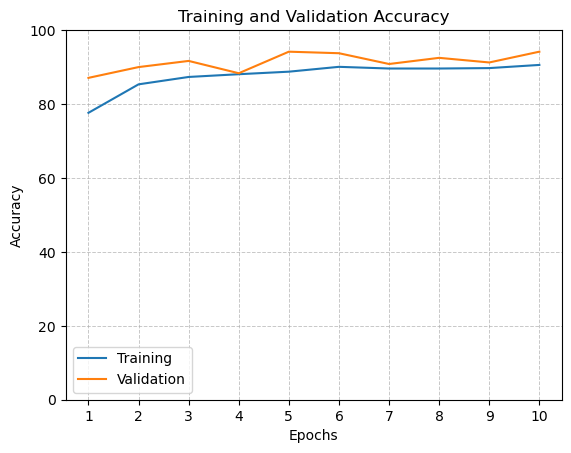

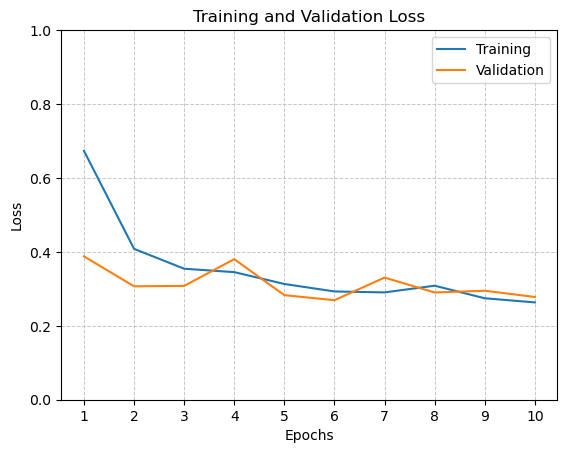

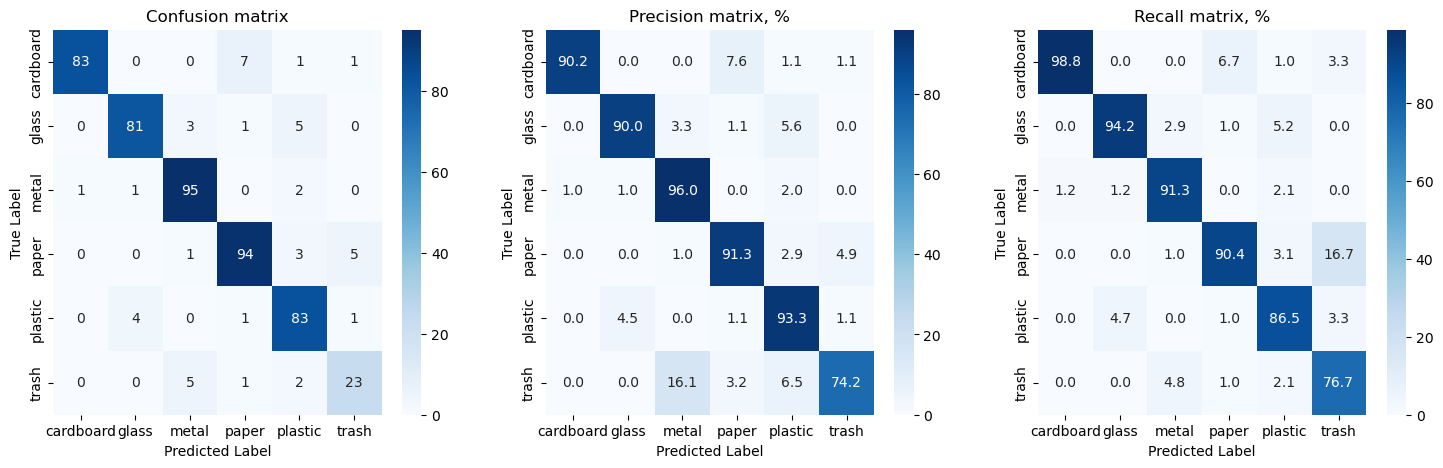

2025-02-19 04:37:20,326 - __main__ - DEBUG - Combination 17/21
2025-02-19 04:37:22,818 - __main__ - DEBUG - train_model() uses mps device
2025-02-19 04:37:22,825 - __main__ - DEBUG - From scratch: True
2025-02-19 04:37:22,825 - __main__ - DEBUG - Source folder: ../Data/raw
2025-02-19 04:37:22,825 - __main__ - DEBUG - New dataset folder: None
2025-02-19 04:37:22,826 - __main__ - DEBUG - Total namber of elements for training - 1770, validation - 252, testing - 505
2025-02-19 04:37:22,827 - __main__ - DEBUG - Learning Rate: 0.00275, LR Decoy: 0.75, Batch size: 24
2025-02-19 04:38:56,148 - __main__ - DEBUG - Epoch [ 1/10]: Train Loss: 0.6862, Train Acc: 77.23%, Val Loss: 0.4106, Val Acc: 86.25%, Time:  93 sec
2025-02-19 04:40:28,695 - __main__ - DEBUG - Epoch [ 2/10]: Train Loss: 0.4043, Train Acc: 86.76%, Val Loss: 0.3466, Val Acc: 88.75%, Time:  93 sec
2025-02-19 04:41:57,693 - __main__ - DEBUG - Epoch [ 3/10]: Train Loss: 0.3478, Train Acc: 88.41%, Val Loss: 0.3310, Val Acc: 89.17%, Tim

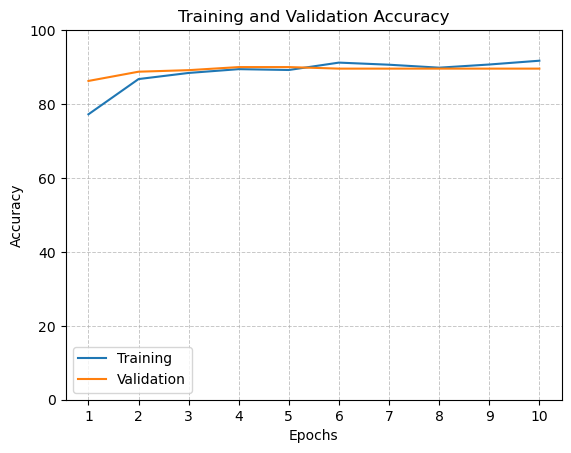

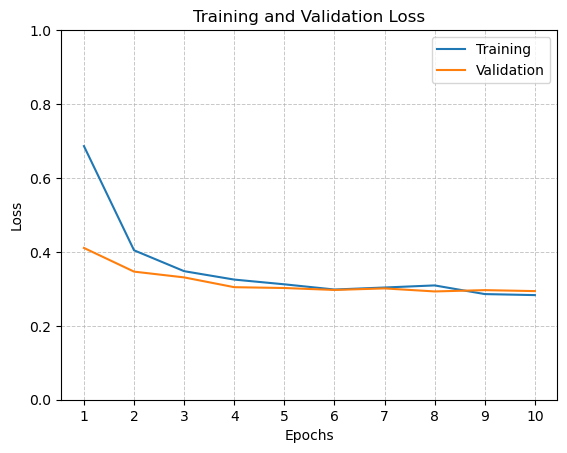

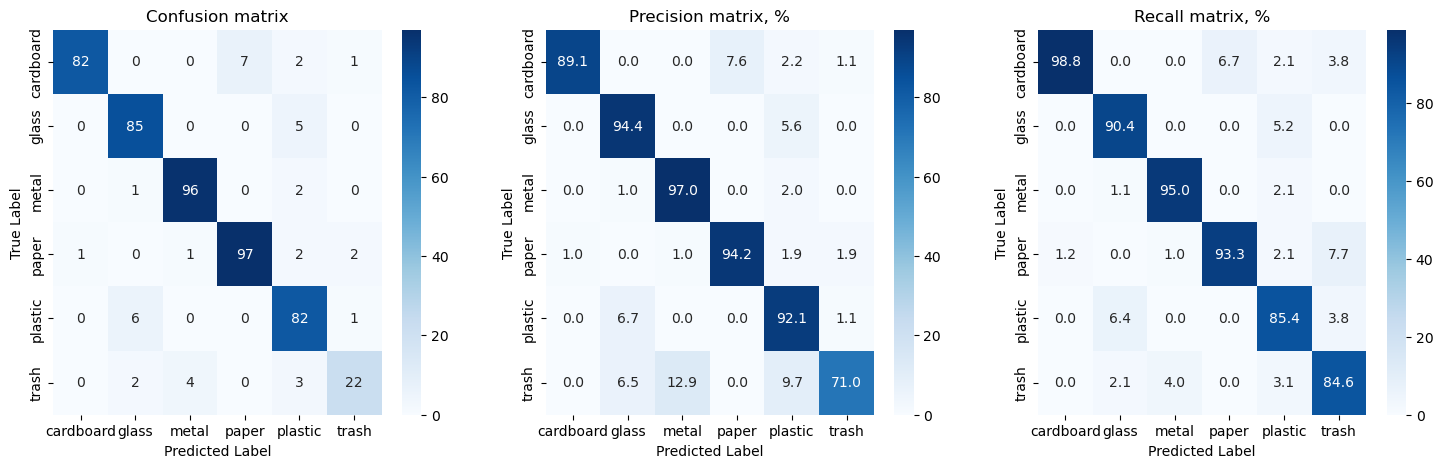

2025-02-19 04:53:41,815 - __main__ - DEBUG - Combination 18/21
2025-02-19 04:53:44,204 - __main__ - DEBUG - train_model() uses mps device
2025-02-19 04:53:44,206 - __main__ - DEBUG - From scratch: True
2025-02-19 04:53:44,206 - __main__ - DEBUG - Source folder: ../Data/raw
2025-02-19 04:53:44,207 - __main__ - DEBUG - New dataset folder: None
2025-02-19 04:53:44,207 - __main__ - DEBUG - Total namber of elements for training - 1770, validation - 252, testing - 505
2025-02-19 04:53:44,208 - __main__ - DEBUG - Learning Rate: 0.0025, LR Decoy: 0.75, Batch size: 24
2025-02-19 04:55:17,680 - __main__ - DEBUG - Epoch [ 1/10]: Train Loss: 0.7052, Train Acc: 76.77%, Val Loss: 0.4108, Val Acc: 86.25%, Time:  93 sec
2025-02-19 04:56:45,396 - __main__ - DEBUG - Epoch [ 2/10]: Train Loss: 0.4071, Train Acc: 86.53%, Val Loss: 0.3301, Val Acc: 90.00%, Time:  88 sec
2025-02-19 04:58:12,621 - __main__ - DEBUG - Epoch [ 3/10]: Train Loss: 0.3500, Train Acc: 88.64%, Val Loss: 0.3178, Val Acc: 90.00%, Time

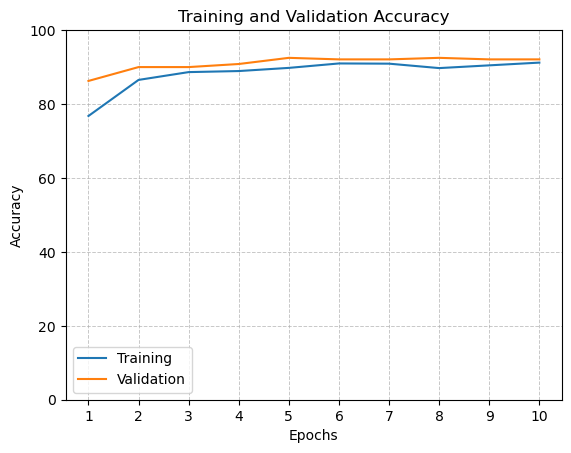

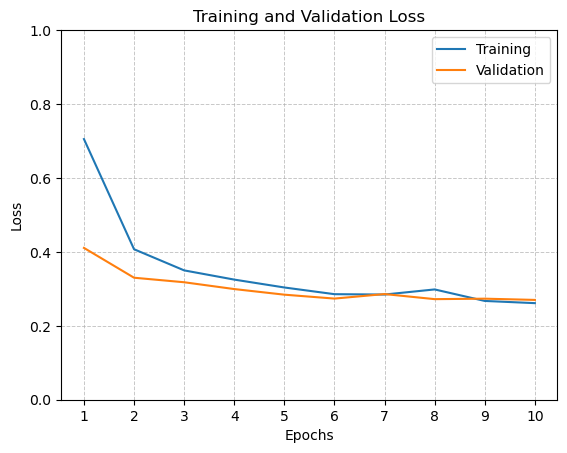

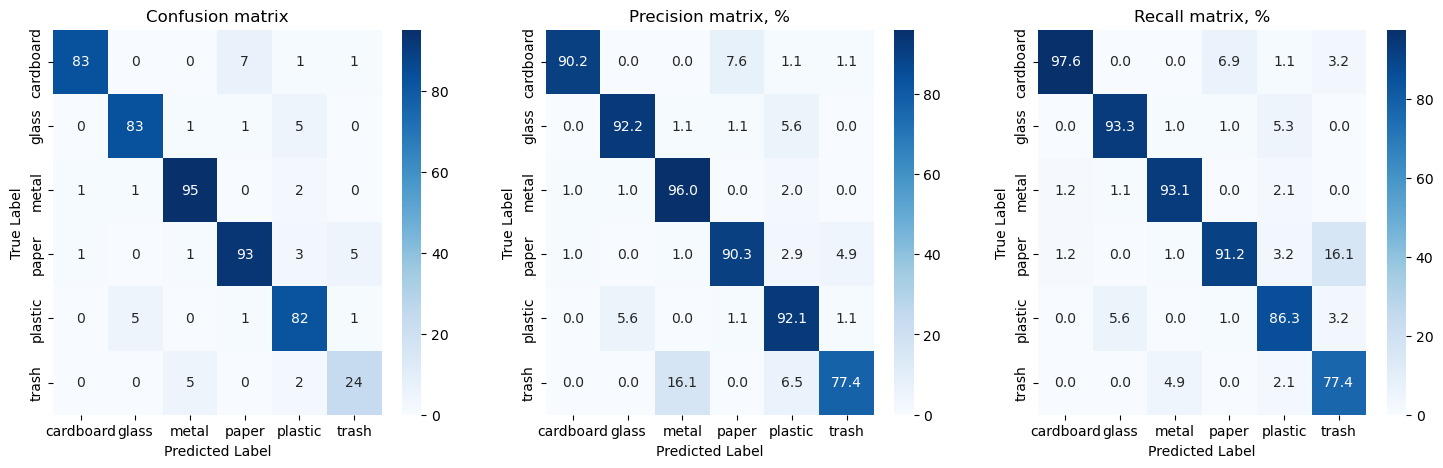

2025-02-19 05:09:58,638 - __main__ - DEBUG - Combination 19/21
2025-02-19 05:10:01,057 - __main__ - DEBUG - train_model() uses mps device
2025-02-19 05:10:01,065 - __main__ - DEBUG - From scratch: True
2025-02-19 05:10:01,066 - __main__ - DEBUG - Source folder: ../Data/raw
2025-02-19 05:10:01,066 - __main__ - DEBUG - New dataset folder: None
2025-02-19 05:10:01,066 - __main__ - DEBUG - Total namber of elements for training - 1770, validation - 252, testing - 505
2025-02-19 05:10:01,068 - __main__ - DEBUG - Learning Rate: 0.00225, LR Decoy: 0.75, Batch size: 24
2025-02-19 05:11:34,696 - __main__ - DEBUG - Epoch [ 1/10]: Train Loss: 0.7266, Train Acc: 76.43%, Val Loss: 0.4195, Val Acc: 86.25%, Time:  94 sec
2025-02-19 05:13:04,487 - __main__ - DEBUG - Epoch [ 2/10]: Train Loss: 0.4174, Train Acc: 86.53%, Val Loss: 0.3419, Val Acc: 89.17%, Time:  90 sec
2025-02-19 05:14:32,933 - __main__ - DEBUG - Epoch [ 3/10]: Train Loss: 0.3576, Train Acc: 88.58%, Val Loss: 0.3255, Val Acc: 90.00%, Tim

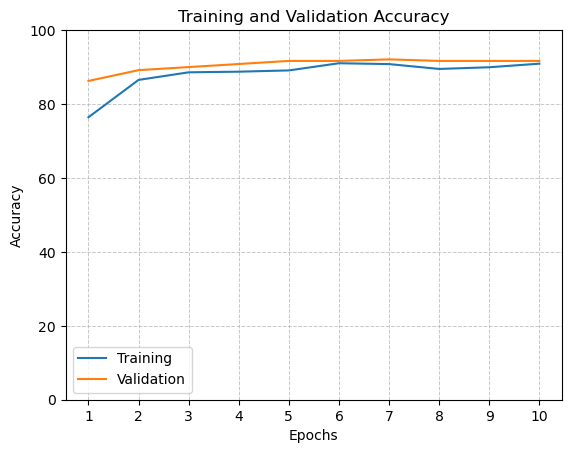

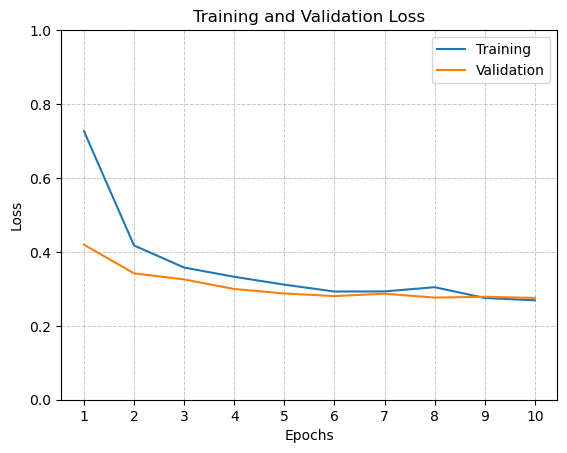

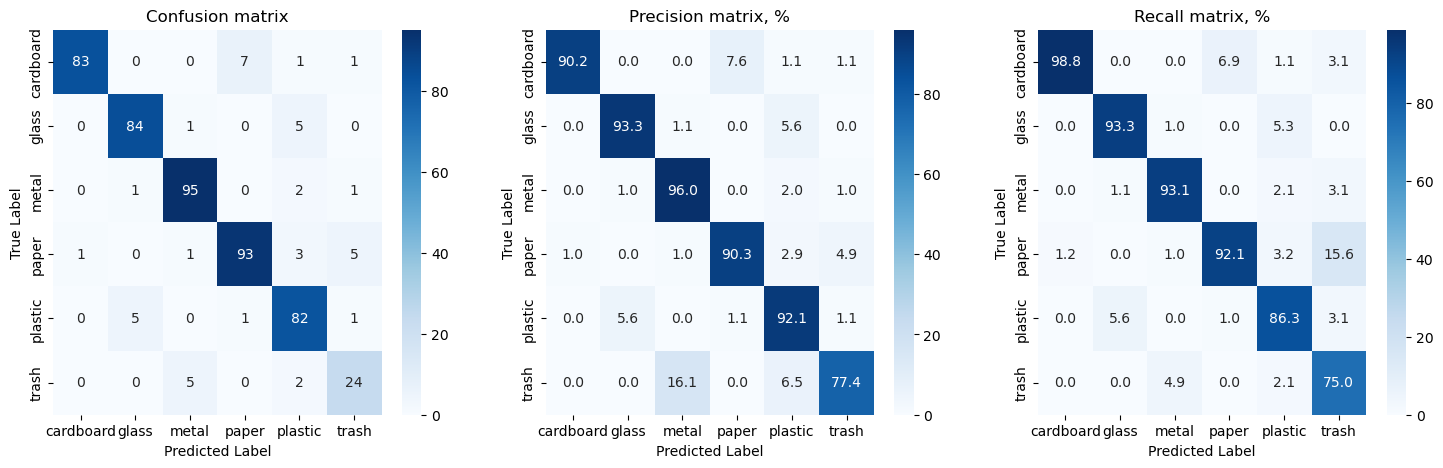

2025-02-19 05:26:16,314 - __main__ - DEBUG - Combination 20/21
2025-02-19 05:26:18,794 - __main__ - DEBUG - train_model() uses mps device
2025-02-19 05:26:18,795 - __main__ - DEBUG - From scratch: True
2025-02-19 05:26:18,796 - __main__ - DEBUG - Source folder: ../Data/raw
2025-02-19 05:26:18,796 - __main__ - DEBUG - New dataset folder: None
2025-02-19 05:26:18,796 - __main__ - DEBUG - Total namber of elements for training - 1770, validation - 252, testing - 505
2025-02-19 05:26:18,797 - __main__ - DEBUG - Learning Rate: 0.002, LR Decoy: 0.75, Batch size: 24
2025-02-19 05:27:51,844 - __main__ - DEBUG - Epoch [ 1/10]: Train Loss: 0.7535, Train Acc: 75.86%, Val Loss: 0.4322, Val Acc: 86.25%, Time:  93 sec
2025-02-19 05:29:21,894 - __main__ - DEBUG - Epoch [ 2/10]: Train Loss: 0.4309, Train Acc: 86.30%, Val Loss: 0.3539, Val Acc: 88.75%, Time:  90 sec
2025-02-19 05:30:49,530 - __main__ - DEBUG - Epoch [ 3/10]: Train Loss: 0.3686, Train Acc: 88.36%, Val Loss: 0.3338, Val Acc: 90.00%, Time:

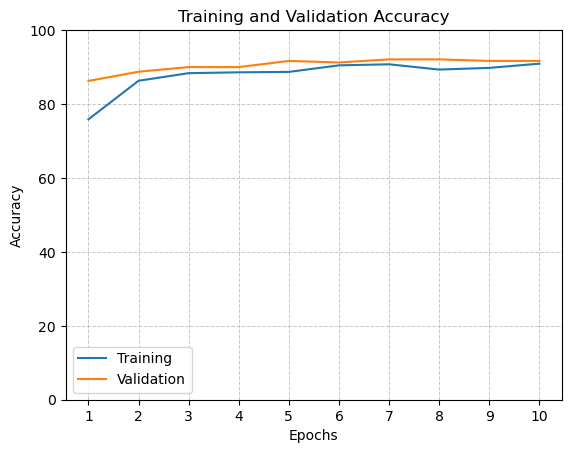

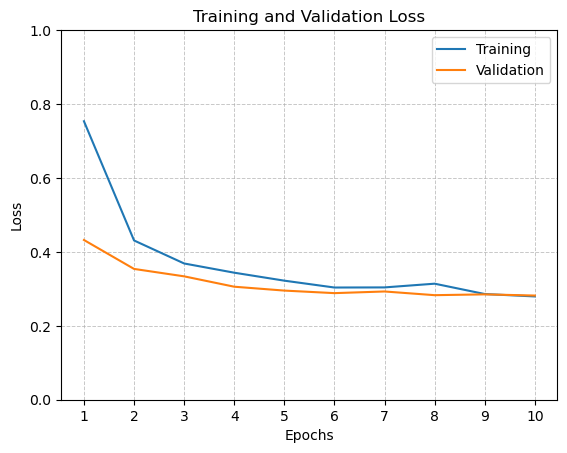

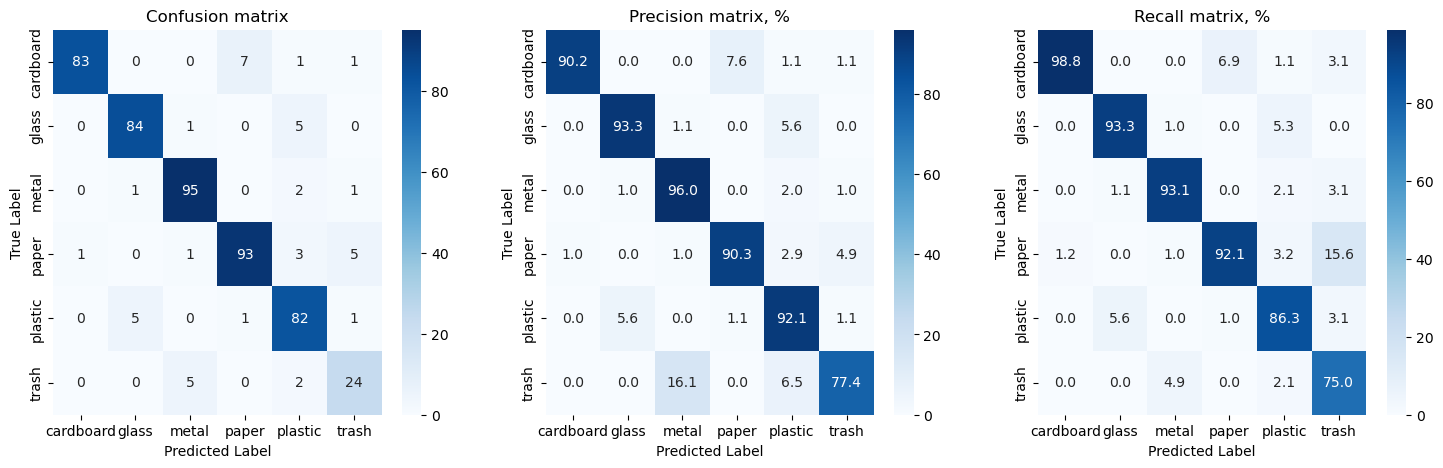

2025-02-19 05:42:25,434 - __main__ - DEBUG - Combination 21/21
2025-02-19 05:42:28,093 - __main__ - DEBUG - train_model() uses mps device
2025-02-19 05:42:28,093 - __main__ - DEBUG - From scratch: True
2025-02-19 05:42:28,094 - __main__ - DEBUG - Source folder: ../Data/raw
2025-02-19 05:42:28,094 - __main__ - DEBUG - New dataset folder: None
2025-02-19 05:42:28,094 - __main__ - DEBUG - Total namber of elements for training - 1770, validation - 252, testing - 505
2025-02-19 05:42:28,095 - __main__ - DEBUG - Learning Rate: 0.001, LR Decoy: 0.75, Batch size: 24
2025-02-19 05:44:02,179 - __main__ - DEBUG - Epoch [ 1/10]: Train Loss: 0.9504, Train Acc: 70.55%, Val Loss: 0.5484, Val Acc: 85.42%, Time:  94 sec
2025-02-19 05:45:31,729 - __main__ - DEBUG - Epoch [ 2/10]: Train Loss: 0.5420, Train Acc: 83.62%, Val Loss: 0.4409, Val Acc: 85.83%, Time:  90 sec
2025-02-19 05:46:59,751 - __main__ - DEBUG - Epoch [ 3/10]: Train Loss: 0.4606, Train Acc: 86.76%, Val Loss: 0.4066, Val Acc: 86.25%, Time:

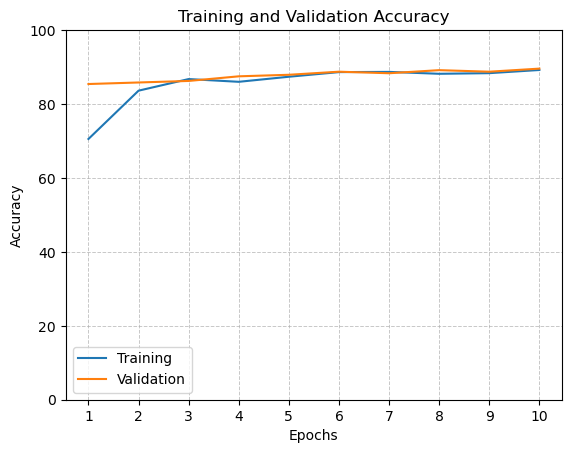

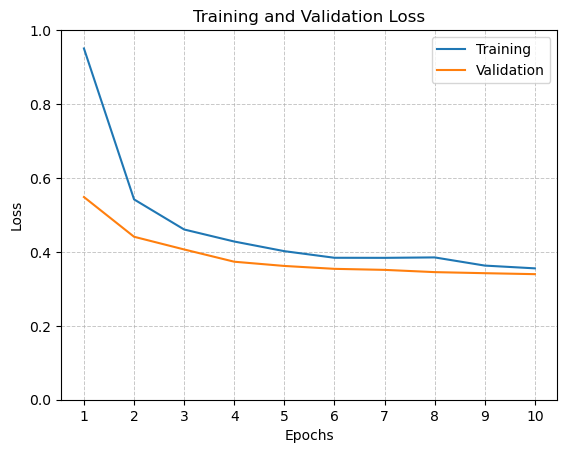

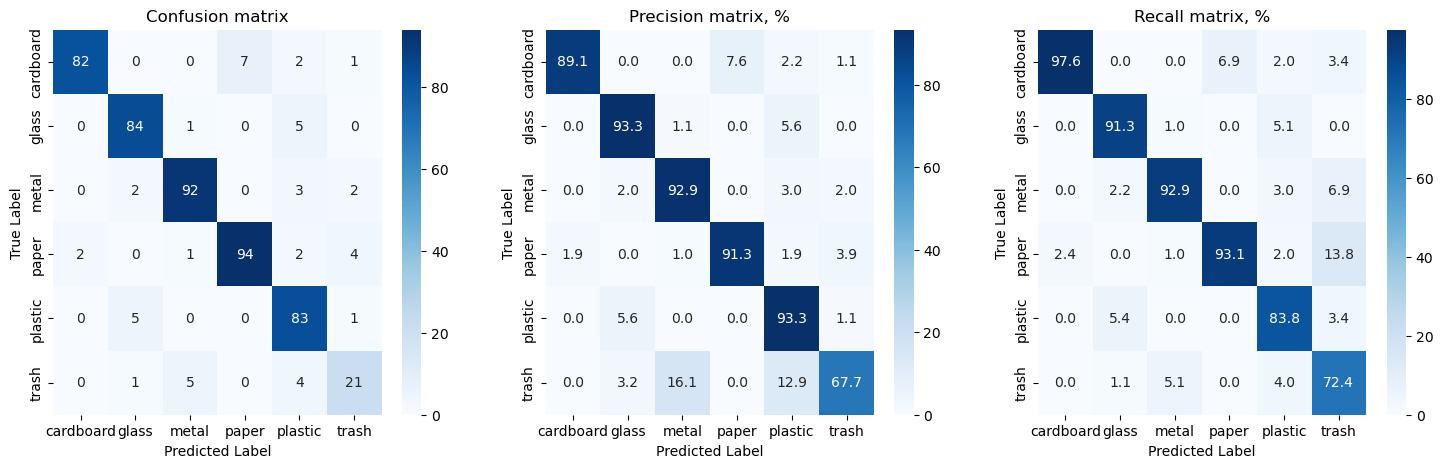

       Iteration  Epoch  Batch  Images_check  Outputs_check      Loss  Images_check_diff  Outputs_check_diff  Loss_diff
0              1      1      0    77773064.0      -7.210514  1.759795                NaN                 NaN        NaN
1              1      1      1   112446928.0     -12.462590  1.612233                NaN                 NaN        NaN
2              1      1      2    48929140.0     -10.159580  1.638814                NaN                 NaN        NaN
3              1      1      3    45788160.0     -20.508339  1.332626                NaN                 NaN        NaN
4              1      1      4    80192816.0     -22.435492  1.005792                NaN                 NaN        NaN
...          ...    ...    ...           ...            ...       ...                ...                 ...        ...
15325         21     10     68   146892000.0     -57.006252  0.178929                0.0           28.998707   0.016492
15326         21     10     69   1135184

In [8]:
# =============================================================================
#                       Main Routine (if run as a script)
# =============================================================================

def main():
    # Create a unique results file name using the current timestamp.
    file_name = f"../results_{time.strftime('%y%m%d_%H%M', time.localtime())}.csv"

    debug_summary = defaultdict(list)

    # Define a parameter grid for hyperparameter experiments.
    param_grid = [
        {
            'BATCH_SIZE': 24,
            'LR_DECOY': [0.85, 0.8, 0.75],
            'INITIAL_LR': [0.004, 0.003, 0.00275, 0.0025, 0.00225, 0.002, 0.001],
        },
        # {
        #     'BATCH_SIZE': 24,
        #     'NUM_EPOCHS': [4, 8, 10]
        #     'LR_DECOY': 0.85,
        #     'INITIAL_LR': 0.00275,
        # },
    ]

    # Generate all possible combinations of parameters from the parameter grid.    
    combinations = get_param_grid(param_grid)

    # Iterate over each hyperparameter combination.    
    for i, combination in enumerate(combinations):
        # Update the global configuration with the current hyperparameter combination and log the current iteration
        change_config(combination)
        my_module_logger.debug(f'{GREEN}Combination {i + 1:d}/{len(combinations)}{RESET}')
        cycle_start_time = time.time()

        # Train the model using the current configuration.
        # This returns statistics for each epoch, test set evaluation, and debug info per batch.
        epoch_stat, test_stat, debug_data = train_model()
        debug_summary[i + 1] = debug_data
        
        # Calculate the elapsed time for the current training cycle.
        elapsed_time = time.time() - cycle_start_time
        my_module_logger.debug(f'Total cycle elapsed time: {elapsed_time // 60:2.0f} min {elapsed_time % 60:2.0f} sec')

        # Log the results of the current cycle to a CSV file.
        log_results(file_name, app_config, test_stat['loss'], test_stat['accuracy'], elapsed_time)

        # If there is validation data and enough epochs were run, plot training/validation metrics.
        if (app_config['VALID_SPLIT_RATIO'] > 0) and (app_config['NUM_EPOCHS'] > 2):
            plot_metrics(epoch_stat['train_accuracy'], epoch_stat['valid_accuracy'], 'Accuracy', 'Training and Validation Accuracy')
            plot_metrics(epoch_stat['train_loss'], epoch_stat['valid_loss'], 'Loss', 'Training and Validation Loss')
        
        # If test data is available and at least one trial is specified, plot the confusion matrix.
        if (app_config['TEST_SPLIT_RATIO'] > 0) and (app_config['NUMBER_OF_TRIALS'] > 0):        
            plot_confusion_matrix(test_stat['y_true'], test_stat['y_pred'], 
                                  test_stat['classes'], None)


    if app_config.get('DEBUG', False):
        # After all iterations, flatten the debug summary (a defaultdict of lists) into a DataFrame.
        df = flatten_defaultdict(debug_summary)
        df = df[['Iteration', 'Epoch', 'Batch', 'Images_check', 'Outputs_check', 'Loss']].sort_values(by = ['Iteration', 'Epoch', 'Batch'])
        
        df_diff = df.copy()
        # Calculate the differences in Images_check, Outputs_check, and Loss grouped by Epoch and Batch.
        df_diff['Images_check_diff'] = df.groupby(['Epoch', 'Batch'])['Images_check'].diff()
        df_diff['Outputs_check_diff'] = df.groupby(['Epoch', 'Batch'])['Outputs_check'].diff()
        df_diff['Loss_diff'] = df.groupby(['Epoch', 'Batch'])['Loss'].diff()
        
        # Print the resulting DataFrame differences with extended display options.
        with pd.option_context('display.width', 200, 'display.max_rows', 200):
            print(df_diff)


if __name__ == '__main__':
    main()
